In [ ]:
!pip install simpleitk
!pip install medpy

# 后面再import、初始化数据集、DataLoader、训练等
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff
from google.colab import drive
import psutil
import sys
import gc
from glob import glob
from scipy.ndimage import label


# Print versions for reproducibility
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"SimpleITK version: {sitk.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA L4
SimpleITK version: 2.5.0
NumPy version: 2.0.2


In [ ]:
# =========================================
# 全局配置
# =========================================
# 调试和可视化设置
debug_vis = False  # 设置为True启用调试可视化
visualization_dir = 'visualizations'  # 会在后面与THREESTAGE_DIR结合
os.makedirs(visualization_dir, exist_ok=True)

# 骨头ID映射表
bone_ids = {
    '骶骨': 1,
    'sacrum': 1,
    '左髋': 2,
    'left_hip': 2,
    '右髋': 3,
    'right_hip': 3
}


In [ ]:
# ========== Colab路径与目录结构设置 ==========
drive.mount('/content/drive')
BASE_DIR = '/content/drive/MyDrive/ct_segmentation'
THREESTAGE_DIR = os.path.join(BASE_DIR, '3stage')
PATHS = {
    'data': f'{BASE_DIR}/data',
    'models': f'{THREESTAGE_DIR}/models',
    'checkpoints': f'{THREESTAGE_DIR}/checkpoints',
    'results': f'{THREESTAGE_DIR}/results',
    'logs': f'{THREESTAGE_DIR}/logs',
    'roi_cache': f'{THREESTAGE_DIR}/roi_cache'
}
for path in PATHS.values():
    os.makedirs(path, exist_ok=True)

# 1. 创建父目录
os.makedirs('/content/data/images', exist_ok=True)
os.makedirs('/content/data/labels', exist_ok=True)

# 2. 解压
os.system('unzip -q /content/drive/MyDrive/ct_segmentation/data/PENGWIN_CT_train_images.zip -d /content/data/images')
os.system('unzip -q /content/drive/MyDrive/ct_segmentation/data/PENGWIN_CT_train_labels.zip -d /content/data/labels')

# 3. 用本地路径
train_images = '/content/data/images/PENGWIN_CT_train_images'
train_labels = '/content/data/labels/PENGWIN_CT_train_labels'
save_dir1 = os.path.join(PATHS['models'], 'pelvis_stage1')
save_dir2 = os.path.join(PATHS['models'], 'fracture_stage2')
os.makedirs(save_dir1, exist_ok=True)
os.makedirs(save_dir2, exist_ok=True)
roi_cache_dir = PATHS['roi_cache']
os.makedirs(roi_cache_dir, exist_ok=True)

# 自动划分训练集和验证集
all_image_files = sorted([f for f in os.listdir(train_images) if f.endswith('.mha')])
all_label_files = sorted([f for f in os.listdir(train_labels) if f.endswith('.mha')])
val_ratio = 0.1
val_num = int(len(all_image_files) * val_ratio)
train_image_files = all_image_files[:-val_num] if val_num > 0 else all_image_files
val_image_files = all_image_files[-val_num:] if val_num > 0 else []
train_label_files = all_label_files[:-val_num] if val_num > 0 else all_label_files
val_label_files = all_label_files[-val_num:] if val_num > 0 else []
train_image_paths = [os.path.join(train_images, f) for f in train_image_files]
train_label_paths = [os.path.join(train_labels, f) for f in train_label_files]
val_image_paths = [os.path.join(train_images, f) for f in val_image_files]
val_label_paths = [os.path.join(train_labels, f) for f in val_label_files]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. 网络结构定义（UNet3D，DepthwiseSeparableConv3d，AttentionGate，SEBlock）
# ---- 直接复制你Unet_colab.py中的网络结构定义 ----
class DepthwiseSeparableConv3d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv3d, self).__init__()
        self.depthwise = nn.Conv3d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        def conv_block(in_ch, out_ch):
            class SEBlock(nn.Module):
                def __init__(self, channel, reduction=16):
                    super(SEBlock, self).__init__()
                    self.avg_pool = nn.AdaptiveAvgPool3d(1)
                    self.fc = nn.Sequential(
                        nn.Linear(channel, channel // reduction, bias=False),
                        nn.ReLU(inplace=True),
                        nn.Linear(channel // reduction, channel, bias=False),
                        nn.Sigmoid()
                    )
                def forward(self, x):
                    b, c, _, _, _ = x.size()
                    y = self.avg_pool(x).view(b, c)
                    y = self.fc(y).view(b, c, 1, 1, 1)
                    return x * y.expand_as(x)
            return nn.Sequential(
                DepthwiseSeparableConv3d(in_ch, out_ch),
                nn.BatchNorm3d(out_ch),
                nn.ReLU(inplace=True),
                DepthwiseSeparableConv3d(out_ch, out_ch),
                nn.BatchNorm3d(out_ch),
                nn.ReLU(inplace=True),
                SEBlock(out_ch)
            )
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        self.attention1 = AttentionGate(512, 512, 256)
        self.attention2 = AttentionGate(256, 256, 128)
        self.attention3 = AttentionGate(128, 128, 64)
        self.attention4 = AttentionGate(64, 64, 32)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.bottleneck = conv_block(512, 1024)
        self.upconv4 = nn.ConvTranspose3d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        self.output = nn.Sequential(
            nn.Conv3d(64, out_channels, kernel_size=1),
            nn.BatchNorm3d(out_channels)
        )
        self.dropout = nn.Dropout3d(p=0.3)
    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.dropout(self.pool(e1)))
        e3 = self.encoder3(self.dropout(self.pool(e2)))
        e4 = self.encoder4(self.dropout(self.pool(e3)))
        b = self.bottleneck(self.dropout(self.pool(e4)))
        d4 = self.upconv4(b)
        e4 = self.attention1(d4, e4)
        d4 = self.decoder4(torch.cat((e4, d4), dim=1))
        d3 = self.upconv3(d4)
        e3 = self.attention2(d3, e3)
        d3 = self.decoder3(torch.cat((e3, d3), dim=1))
        d2 = self.upconv2(d3)
        e2 = self.attention3(d2, e2)
        d2 = self.decoder2(torch.cat((e2, d2), dim=1))
        d1 = self.upconv1(d2)
        e1 = self.attention4(d1, e1)
        d1 = self.decoder1(torch.cat((e1, d1), dim=1))
        return self.output(d1)
# 标签重映射函数（骨盆分割阶段）
def relabel_pelvis(label):
    new_label = np.zeros_like(label, dtype=np.int64)
    new_label[np.isin(label, np.arange(1,11))] = 1
    new_label[np.isin(label, np.arange(11,21))] = 2
    new_label[np.isin(label, np.arange(21,31))] = 3
    return new_label

In [ ]:
# 3. 阶段1：骨盆分割
class PelvisSegDataset(Dataset):
    def __init__(self, images_path, labels_path, resize_shape=(320,256,256), augment=False):
        if isinstance(images_path, str):
            self.image_paths = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.mha')])
        else:
            self.image_paths = list(images_path)
        if isinstance(labels_path, str):
            self.label_paths = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.mha')])
        else:
            self.label_paths = list(labels_path)
        self.resize_shape = resize_shape
        self.augment = augment
    def __len__(self):
        return len(self.image_paths)
    def preprocess(self, image):
        image = np.clip(image, 0, 1000)
        image = (image - np.mean(image)) / (np.std(image) + 1e-8)
        from scipy.ndimage import zoom
        scale = [self.resize_shape[i]/image.shape[i] for i in range(3)]
        image = zoom(image, scale, order=1)
        return image
    def relabel(self, label):
        return relabel_pelvis(label)
    def __getitem__(self, idx):
        image = sitk.GetArrayFromImage(sitk.ReadImage(self.image_paths[idx])).astype(np.float32)
        label = sitk.GetArrayFromImage(sitk.ReadImage(self.label_paths[idx])).astype(np.int64)
        image = self.preprocess(image)
        label = self.relabel(label)
        assert label.max() <= 3 and label.min() >= 0, f'Label out of range: min={label.min()}, max={label.max()}'
        if self.augment:
            pass
        image = np.expand_dims(image, axis=0)
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Patch采样数据集（适用于大体积3D数据）
class PatchBasedSegDataset(Dataset):
    def __init__(self, image_paths, label_paths, patch_size=(128,128,128), stride=(26,26,26), augment=False):
        if isinstance(image_paths, str):
            self.image_paths = sorted([os.path.join(image_paths, f) for f in os.listdir(image_paths) if f.endswith('.mha')])
        else:
            self.image_paths = list(image_paths)
        if isinstance(label_paths, str):
            self.label_paths = sorted([os.path.join(label_paths, f) for f in os.listdir(label_paths) if f.endswith('.mha')])
        else:
            self.label_paths = list(label_paths)
        self.patch_size = patch_size
        self.stride = stride
        self.augment = augment
        self.patch_index = []  # (img_idx, d, h, w)
        self._build_patch_index()
    def _build_patch_index(self):
        import SimpleITK as sitk
        for img_idx, img_path in enumerate(self.image_paths):
            image = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            D, H, W = image.shape
            d_steps = range(0, max(1, D - self.patch_size[0] + 1), self.stride[0])
            h_steps = range(0, max(1, H - self.patch_size[1] + 1), self.stride[1])
            w_steps = range(0, max(1, W - self.patch_size[2] + 1), self.stride[2])
            for d in d_steps:
                for h in h_steps:
                    for w in w_steps:
                        self.patch_index.append((img_idx, d, h, w))
    def __len__(self):
        return len(self.patch_index)
    def relabel(self, label):
        return relabel_pelvis(label)
    def __getitem__(self, idx):
        img_idx, d, h, w = self.patch_index[idx]
        import SimpleITK as sitk
        image = sitk.GetArrayFromImage(sitk.ReadImage(self.image_paths[img_idx])).astype(np.float32)
        label = sitk.GetArrayFromImage(sitk.ReadImage(self.label_paths[img_idx])).astype(np.int64)
        patch_img = image[d:d+self.patch_size[0], h:h+self.patch_size[1], w:w+self.patch_size[2]]
        patch_lbl = label[d:d+self.patch_size[0], h:h+self.patch_size[1], w:w+self.patch_size[2]]
        patch_lbl = self.relabel(patch_lbl)
        assert patch_lbl.max() <= 3 and patch_lbl.min() >= 0, f'Patch label out of range: min={patch_lbl.min()}, max={patch_lbl.max()}'
        patch_img = np.clip(patch_img, 0, 1000)
        patch_img = (patch_img - np.mean(patch_img)) / (np.std(patch_img) + 1e-8)
        patch_img = np.expand_dims(patch_img, axis=0)
        return torch.tensor(patch_img, dtype=torch.float32), torch.tensor(patch_lbl, dtype=torch.long)

# 随机patch采样数据集（适合大体积3D数据高效训练）
class RandomPatchSegDataset(Dataset):
    def __init__(self, image_paths, label_paths, patch_size=(128,128,128), num_patches=1000, augment=False):
        self.image_paths = list(image_paths)
        self.label_paths = list(label_paths)
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.augment = augment
        import SimpleITK as sitk
        self.volumes = [sitk.GetArrayFromImage(sitk.ReadImage(p)) for p in self.image_paths]
        self.labels = [sitk.GetArrayFromImage(sitk.ReadImage(p)) for p in self.label_paths]
    def __len__(self):
        return self.num_patches
    def __getitem__(self, idx):
        import random
        vol_idx = random.randint(0, len(self.volumes)-1)
        image = self.volumes[vol_idx]
        label = self.labels[vol_idx]
        D, H, W = image.shape
        pd, ph, pw = self.patch_size
        d = random.randint(0, max(1, D-pd))
        h = random.randint(0, max(1, H-ph))
        w = random.randint(0, max(1, W-pw))
        patch_img = image[d:d+pd, h:h+ph, w:w+pw]
        patch_lbl = label[d:d+pd, h:h+ph, w:w+pw]
        patch_lbl = relabel_pelvis(patch_lbl)
        assert patch_lbl.max() <= 3 and patch_lbl.min() >= 0, f'Patch label out of range: min={patch_lbl.min()}, max={patch_lbl.max()}'
        patch_img = np.clip(patch_img, 0, 1000)
        patch_img = (patch_img - np.mean(patch_img)) / (np.std(patch_img) + 1e-8)
        patch_img = np.expand_dims(patch_img, axis=0)
        # 数据增强
        if self.augment:
            patch_img, patch_lbl = random_flip(patch_img, patch_lbl)
        return torch.tensor(patch_img, dtype=torch.float32), torch.tensor(patch_lbl, dtype=torch.long)

# ========== 权重转换函数 ==========
def convert_weights(checkpoint_dict, num_classes):
    """
    Convert weights from binary classification to multi-class classification
    Only converts the final layer weights, keeps other layers unchanged
    """
    new_state_dict = checkpoint_dict['model_state_dict']
    old_output_weight = new_state_dict['output.0.weight']  # Shape: [1, 64, 1, 1, 1]
    old_output_bias = new_state_dict['output.0.bias']      # Shape: [1]
    new_output_weight = torch.zeros((num_classes, 64, 1, 1, 1), device=old_output_weight.device)
    new_output_bias = torch.zeros(num_classes, device=old_output_bias.device)
    new_output_weight[0] = old_output_weight[0]
    new_output_bias[0] = old_output_bias[0]
    if num_classes > 1:
        nn.init.xavier_uniform_(new_output_weight[1:])
        nn.init.zeros_(new_output_bias[1:])
    new_state_dict['output.0.weight'] = new_output_weight
    new_state_dict['output.0.bias'] = new_output_bias
    new_state_dict['output.1.weight'] = torch.ones(num_classes)
    new_state_dict['output.1.bias'] = torch.zeros(num_classes)
    new_state_dict['output.1.running_mean'] = torch.zeros(num_classes)
    new_state_dict['output.1.running_var'] = torch.ones(num_classes)
    checkpoint_dict['model_state_dict'] = new_state_dict
    return checkpoint_dict

# ========== 滑动窗口预测 ==========
def predict_volume(model, image, patch_size=(128, 128, 128), stride=(26, 26, 26), num_classes=4, device=None):
    """Predict segmentation using sliding window approach"""
    model.eval()
    if device is None:
        device = next(model.parameters()).device
    D, H, W = image.shape
    output = np.zeros((num_classes, D, H, W), dtype=np.float32)
    weight = np.zeros((num_classes, D, H, W), dtype=np.float32)
    d_steps = range(0, D - patch_size[0] + 1, stride[0])
    h_steps = range(0, H - patch_size[1] + 1, stride[1])
    w_steps = range(0, W - patch_size[2] + 1, stride[2])
    if D < patch_size[0]: d_steps = [0]
    if H < patch_size[1]: h_steps = [0]
    if W < patch_size[2]: w_steps = [0]
    with torch.no_grad():
        for d in d_steps:
            for h in h_steps:
                for w in w_steps:
                    d_end = min(d + patch_size[0], D)
                    h_end = min(h + patch_size[1], H)
                    w_end = min(w + patch_size[2], W)
                    patch = image[d:d_end, h:h_end, w:w_end]
                    pad_d, pad_h, pad_w = 0, 0, 0
                    if patch.shape != patch_size:
                        pad_d = patch_size[0] - patch.shape[0]
                        pad_h = patch_size[1] - patch.shape[1]
                        pad_w = patch_size[2] - patch.shape[2]
                        patch = np.pad(patch, ((0, pad_d), (0, pad_h), (0, pad_w)), mode='constant')
                    patch = torch.tensor(patch).float().unsqueeze(0).unsqueeze(0).to(device)
                    pred = model(patch)
                    pred = torch.softmax(pred, dim=1).cpu().numpy()[0]
                    if pad_d > 0 or pad_h > 0 or pad_w > 0:
                        pred = pred[:, :d_end-d, :h_end-h, :w_end-w]
                    output[:, d:d_end, h:h_end, w:w_end] += pred
                    weight[:, d:d_end, h:h_end, w:w_end] += 1
    output = np.divide(output, weight, where=weight!=0)
    final_prediction = np.argmax(output, axis=0)
    return final_prediction

# ========== 训练监控 ==========
class TrainingMonitor:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []
        self.current_epoch = 0
        self.best_loss = float('inf')
        self.best_dice = 0
    def update(self, train_loss, val_loss, learning_rate):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.learning_rates.append(learning_rate)
        self.current_epoch += 1
        if val_loss is not None and val_loss < self.best_loss:
            self.best_loss = val_loss
        # best_dice由外部调用时赋值
    def plot_progress(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Val Loss')
        ax1.set_title('Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        ax2.plot(self.learning_rates, label='Learning Rate')
        ax2.set_title('Learning Rate')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('LR')
        ax2.legend()
        ax2.grid(True)
        plt.tight_layout()
        plt.show()
    def print_stats(self):
        print(f"Current epoch: {self.current_epoch}")
        print(f"Best loss: {self.best_loss:.4f}")
        print(f"Current loss: {self.train_losses[-1]:.4f}")
        print(f"Current learning rate: {self.learning_rates[-1]:.6f}")
        print(f"Best dice: {self.best_dice:.4f}")

# ========== 修改训练主循环，集成monitor和scheduler ==========
def train_pelvis_segmentation(train_dataset, val_dataset, save_dir, num_classes=4, lr=0.001, batch_size=1, num_epochs=100, patch_mode=False, patch_size=(128,128,128), stride=(26,26,26), accumulation_steps=1, resume_from=None):
    import torch
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet3D(in_channels=1, out_channels=num_classes).to(device)
    # 类别权重
    print('Calculating class weights...')
    class_weights = calculate_class_weights_from_files(train_label_paths, num_classes, device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    monitor = TrainingMonitor()
    best_loss = float('inf')
    best_dice = 0
    start_epoch = 0
    # 断点续训
    if resume_from is not None and os.path.exists(resume_from):
        print(f'Loading checkpoint from {resume_from}')
        checkpoint = torch.load(resume_from, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_loss = checkpoint.get('best_loss', float('inf'))
        best_dice = checkpoint.get('best_dice', 0)
        monitor.best_loss = best_loss
        monitor.best_dice = best_dice
        print(f'Resumed from epoch {start_epoch}, best_loss={best_loss:.4f}, best_dice={best_dice:.4f}')
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True, leave=True, file=sys.stdout)):
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=(scaler is not None)):
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss = loss / accumulation_steps
            if scaler is not None:
                scaler.scale(loss).backward()
            else:
                loss.backward()
            if (batch_idx + 1) % accumulation_steps == 0:
                if scaler is not None:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad()
            running_loss += loss.item() * accumulation_steps
        avg_loss = running_loss / len(train_loader)
        # 每个epoch都评估val loss
        model.eval()
        val_loss = 0.0
        patch_mean_dices = []
        val_vis_saved = False
        with torch.no_grad():
            for val_idx, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                labels_np = labels.cpu().numpy()
                # --- 新增：可视化一个patch ---
                if (epoch+1) % 5 == 0 and not val_vis_saved:
                    img_np = images.cpu().numpy()[0,0]
                    pred_np = preds[0]
                    label_np = labels_np[0]
                    mid = img_np.shape[0] // 2
                    fig, axs = plt.subplots(1,3,figsize=(12,4))
                    axs[0].imshow(img_np[mid], cmap='gray')
                    axs[0].set_title('CT')
                    axs[1].imshow(label_np[mid], cmap='tab10', vmin=0, vmax=num_classes-1)
                    axs[1].set_title('Label')
                    axs[2].imshow(pred_np[mid], cmap='tab10', vmin=0, vmax=num_classes-1)
                    axs[2].set_title('Pred')
                    for ax in axs: ax.axis('off')
                    plt.tight_layout()
                    vis_path = os.path.join(save_dir, f'val_patch_epoch{epoch+1}.png')
                    plt.savefig(vis_path)
                    plt.close(fig)
                    print(f'[Epoch {epoch+1}] 验证集patch可视化已保存: {vis_path}')
                    val_vis_saved = True
                # --- 新增：打印类别分布 ---
                if val_idx == 0 and (epoch+1) % 5 == 0:
                    print(f'[Epoch {epoch+1}] 验证batch类别分布: pred={np.unique(preds, return_counts=True)}, label={np.unique(labels_np, return_counts=True)}')
                # --- dice per class, then patch mean ---
                patch_dices = []
                for c in range(1, num_classes):
                    pred_c = (preds == c)
                    gt_c = (labels_np == c)
                    intersection = (pred_c & gt_c).sum()
                    denom = pred_c.sum() + gt_c.sum()
                    dice = (2. * intersection) / (denom + 1e-7) if denom > 0 else np.nan
                    patch_dices.append(dice)
                    if val_idx == 0 and (epoch+1) % 5 == 0:
                        print(f'[Epoch {epoch+1}] 类别{c} dice: {dice:.4f} (pred像素={pred_c.sum()}, label像素={gt_c.sum()})')
                patch_mean = np.nanmean(patch_dices)
                patch_mean_dices.append(patch_mean)
                # --- dice极低时保存patch ---
                if val_idx == 0 and patch_mean < 0.1:
                    np.save(os.path.join(save_dir, f'debug_pred_epoch{epoch+1}.npy'), preds)
                    np.save(os.path.join(save_dir, f'debug_label_epoch{epoch+1}.npy'), labels_np)
                    print(f'[Epoch {epoch+1}] mean dice极低，已保存pred/label patch到npy便于排查')
        avg_val_loss = val_loss / len(val_loader)
        mean_dice = np.nanmean(patch_mean_dices) if patch_mean_dices else 0
        print(f'Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {mean_dice:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        monitor.update(avg_loss, avg_val_loss, optimizer.param_groups[0]['lr'])
        monitor.best_dice = max(monitor.best_dice, mean_dice)
        checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1:03d}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_loss': monitor.best_loss,
            'best_dice': monitor.best_dice
        }, checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_pelvis_model.pth'))
            print('Best model saved.')
        scheduler.step(avg_loss)
        if (epoch + 1) % 10 == 0:
            monitor.plot_progress()
            monitor.print_stats()
    return model

# 4. 阶段2：骨折分割
class FractureSegDataset(Dataset):
    def __init__(self, roi_images, roi_labels, resize_shape=(256,256,256), augment=False):
        self.roi_images = roi_images
        self.roi_labels = roi_labels
        self.resize_shape = resize_shape
        self.augment = augment
    def __len__(self):
        return len(self.roi_images)
    def preprocess(self, image):
        image = np.clip(image, 0, 1000)
        image = (image - np.mean(image)) / (np.std(image) + 1e-8)
        from scipy.ndimage import zoom
        scale = [self.resize_shape[i]/image.shape[i] for i in range(3)]
        image = zoom(image, scale, order=1)
        return image
    def __getitem__(self, idx):
        image = self.preprocess(self.roi_images[idx])
        label = self.roi_labels[idx]  # 直接使用ROI缓存中的0-10标签
        # 标签应为0-10，且与模型输出一致
        if self.augment:
            pass
        image = np.expand_dims(image, axis=0)
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# 新增：骨折分割patch采样数据集，防止显存溢出
class FracturePatchDataset(Dataset):
    def __init__(self, roi_images, roi_labels, patch_size=(64,64,64), num_patches=1000, augment=False):
        self.roi_images = roi_images
        self.roi_labels = roi_labels
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.augment = augment
    def __len__(self):
        return self.num_patches
    def __getitem__(self, idx):
        import random
        import numpy as np
        vol_idx = random.randint(0, len(self.roi_images)-1)
        image = self.roi_images[vol_idx]
        label = self.roi_labels[vol_idx]  # 直接使用ROI缓存中的0-10标签
        # 标签应为0-10，且与模型输出一致
        D, H, W = image.shape
        pd, ph, pw = self.patch_size
        d = random.randint(0, max(1, D-pd))
        h = random.randint(0, max(1, H-ph))
        w = random.randint(0, max(1, W-pw))
        patch_img = image[d:d+pd, h:h+ph, w:w+pw]
        patch_lbl = label[d:d+pd, h:h+ph, w:w+pw]
        # pad if needed
        pad_width = [
            (0, max(0, pd - patch_img.shape[0])),
            (0, max(0, ph - patch_img.shape[1])),
            (0, max(0, pw - patch_img.shape[2]))
        ]
        patch_img = np.pad(patch_img, pad_width, mode='constant')
        patch_lbl = np.pad(patch_lbl, pad_width, mode='constant')
        patch_img = np.clip(patch_img, 0, 1000)
        patch_img = (patch_img - np.mean(patch_img)) / (np.std(patch_img) + 1e-8)
        patch_img = np.expand_dims(patch_img, axis=0)
        if self.augment:
            patch_img, patch_lbl = random_flip(patch_img, patch_lbl)
        return torch.tensor(patch_img, dtype=torch.float32), torch.tensor(patch_lbl, dtype=torch.long)


def train_fracture_segmentation(train_dataset, val_dataset, save_dir, num_classes=11, lr=0.001, batch_size=1, num_epochs=50, patch_mode=False, patch_size=(128,128,128), stride=(26,26,26), accumulation_steps=1, resume_from=None):
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet3D(in_channels=1, out_channels=num_classes).to(device)
    print('Calculating class weights...')
    class_weights = calculate_class_weights_from_files(train_label_paths, num_classes, device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    monitor = TrainingMonitor()
    best_loss = float('inf')
    best_dice = 0
    start_epoch = 0
    if resume_from is not None and os.path.exists(resume_from):
        print(f'Loading checkpoint from {resume_from}')
        checkpoint = torch.load(resume_from, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_loss = checkpoint.get('best_loss', float('inf'))
        best_dice = checkpoint.get('best_dice', 0)
        monitor.best_loss = best_loss
        monitor.best_dice = best_dice
        print(f'Resumed from epoch {start_epoch}, best_loss={best_loss:.4f}, best_dice={best_dice:.4f}')
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True, leave=True, file=sys.stdout)):
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=(scaler is not None)):
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss = loss / accumulation_steps
            if scaler is not None:
                scaler.scale(loss).backward()
            else:
                loss.backward()
            if (batch_idx + 1) % accumulation_steps == 0:
                if scaler is not None:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad()
            running_loss += loss.item() * accumulation_steps
            # --- 新增：打印一个batch的类别分布 ---
            if batch_idx == 0 and epoch % 5 == 0:
                pred = torch.argmax(outputs, dim=1).cpu().numpy()
                lbl = labels.cpu().numpy()
                print(f'[Epoch {epoch+1}] 训练batch类别分布: pred={np.unique(pred, return_counts=True)}, label={np.unique(lbl, return_counts=True)}')
        avg_loss = running_loss / len(train_loader)
        # 每个epoch都评估val loss
        model.eval()
        val_loss = 0.0
        patch_mean_dices = []
        val_vis_saved = False
        with torch.no_grad():
            for val_idx, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                labels_np = labels.cpu().numpy()
                # --- 新增：可视化一个patch ---
                if (epoch+1) % 5 == 0 and not val_vis_saved:
                    img_np = images.cpu().numpy()[0,0]
                    pred_np = preds[0]
                    label_np = labels_np[0]
                    mid = img_np.shape[0] // 2
                    fig, axs = plt.subplots(1,3,figsize=(12,4))
                    axs[0].imshow(img_np[mid], cmap='gray')
                    axs[0].set_title('CT')
                    axs[1].imshow(label_np[mid], cmap='tab10', vmin=0, vmax=num_classes-1)
                    axs[1].set_title('Label')
                    axs[2].imshow(pred_np[mid], cmap='tab10', vmin=0, vmax=num_classes-1)
                    axs[2].set_title('Pred')
                    for ax in axs: ax.axis('off')
                    plt.tight_layout()
                    vis_path = os.path.join(save_dir, f'val_patch_epoch{epoch+1}.png')
                    plt.savefig(vis_path)
                    plt.close(fig)
                    print(f'[Epoch {epoch+1}] 验证集patch可视化已保存: {vis_path}')
                    val_vis_saved = True
                # --- 新增：打印类别分布 ---
                if val_idx == 0 and (epoch+1) % 5 == 0:
                    print(f'[Epoch {epoch+1}] 验证batch类别分布: pred={np.unique(preds, return_counts=True)}, label={np.unique(labels_np, return_counts=True)}')
                # --- dice per class, then patch mean ---
                patch_dices = []
                for c in range(1, num_classes):
                    pred_c = (preds == c)
                    gt_c = (labels_np == c)
                    intersection = (pred_c & gt_c).sum()
                    denom = pred_c.sum() + gt_c.sum()
                    dice = (2. * intersection) / (denom + 1e-7) if denom > 0 else np.nan
                    patch_dices.append(dice)
                    if val_idx == 0 and (epoch+1) % 5 == 0:
                        print(f'[Epoch {epoch+1}] 类别{c} dice: {dice:.4f} (pred像素={pred_c.sum()}, label像素={gt_c.sum()})')
                patch_mean = np.nanmean(patch_dices)
                patch_mean_dices.append(patch_mean)
                # --- dice极低时保存patch ---
                if val_idx == 0 and patch_mean < 0.1:
                    np.save(os.path.join(save_dir, f'debug_pred_epoch{epoch+1}.npy'), preds)
                    np.save(os.path.join(save_dir, f'debug_label_epoch{epoch+1}.npy'), labels_np)
                    print(f'[Epoch {epoch+1}] mean dice极低，已保存pred/label patch到npy便于排查')
        avg_val_loss = val_loss / len(val_loader)
        mean_dice = np.nanmean(patch_mean_dices) if patch_mean_dices else 0
        print(f'Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Mean Dice: {mean_dice:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        monitor.update(avg_loss, avg_val_loss, optimizer.param_groups[0]['lr'])
        monitor.best_dice = max(monitor.best_dice, mean_dice)
        checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1:03d}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_loss': monitor.best_loss,
            'best_dice': monitor.best_dice
        }, checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_fracture_model.pth'))
            print('Best model saved.')
        scheduler.step(avg_loss)
        if (epoch + 1) % 10 == 0:
            monitor.plot_progress()
            monitor.print_stats()
    return model


# 5. 阶段3：级联分割推理
def cascaded_inference(pelvis_model, fracture_model, image, device):
    # 用滑动窗口推理pelvis
    pelvis_pred = predict_volume(
        pelvis_model, image, patch_size=(128,128,128), stride=(64,64,64), num_classes=4, device=device
    )

    # 确定感兴趣区域的标签范围（骶骨=1, 左髋=2, 右髋=3）
    target_bone = 1  # 默认为骶骨

    # 根据target_bone确定标签范围
    if target_bone == 1:  # 骶骨
        label_range = (1, 10)
    elif target_bone == 2:  # 左髋
        label_range = (11, 20)
    elif target_bone == 3:  # 右髋
        label_range = (21, 30)

    # 使用预测结果创建掩码
    roi_mask = (pelvis_pred == target_bone)

    # 提取ROI
    roi_img, roi_mask, bbox = extract_roi_from_mask(image, roi_mask, margin=10)
    if roi_img is None:
        print("未找到骨盆区域")
        return None

    # 用滑动窗口推理fracture
    fracture_pred = predict_volume(
        fracture_model, roi_img, patch_size=(128,128,128), stride=(64,64,64), num_classes=11, device=device
    )

    # 创建结果图像
    result = np.zeros_like(image, dtype=np.int64)
    result[bbox['dmin']:bbox['dmax']+1,
           bbox['hmin']:bbox['hmax']+1,
           bbox['wmin']:bbox['wmax']+1] = fracture_pred

    return result

# 6. 可视化与评估函数
from scipy.spatial.distance import directed_hausdorff

def dice_score(pred, gt, num_classes):
    """多类别Dice，返回每个类别和平均Dice"""
    dices = []
    for c in range(1, num_classes):  # 跳过背景
        pred_c = (pred == c)
        gt_c = (gt == c)
        intersection = np.sum(pred_c & gt_c)
        denom = np.sum(pred_c) + np.sum(gt_c)
        dice = (2. * intersection) / (denom + 1e-7) if denom > 0 else np.nan
        dices.append(dice)
    return dices, np.nanmean(dices)

def iou_score(pred, gt, num_classes):
    """多类别IoU，返回每个类别和平均IoU"""
    ious = []
    for c in range(1, num_classes):
        pred_c = (pred == c)
        gt_c = (gt == c)
        intersection = np.sum(pred_c & gt_c)
        union = np.sum(pred_c | gt_c)
        iou = intersection / (union + 1e-7) if union > 0 else np.nan
        ious.append(iou)
    return ious, np.nanmean(ious)

def hd95(pred, gt, spacing=(1,1,1), num_classes=4):
    """多类别HD95，返回每个类别和平均HD95"""
    try:
        from medpy.metric.binary import hd95 as medpy_hd95
    except ImportError:
        print('请先pip install medpy')
        return [np.nan]*num_classes, np.nan
    hd95s = []
    for c in range(1, num_classes):
        pred_c = (pred == c)
        gt_c = (gt == c)
        if np.sum(pred_c) == 0 or np.sum(gt_c) == 0:
            hd95s.append(np.nan)
        else:
            try:
                hd = medpy_hd95(pred_c, gt_c, voxelspacing=spacing)
            except Exception:
                hd = np.nan
            hd95s.append(hd)
    return hd95s, np.nanmean(hd95s)

def assd(pred, gt, spacing=(1,1,1), num_classes=4):
    """多类别ASSD，返回每个类别和平均ASSD"""
    try:
        from medpy.metric.binary import assd as medpy_assd
    except ImportError:
        print('请先pip install medpy')
        return [np.nan]*num_classes, np.nan
    assds = []
    for c in range(1, num_classes):
        pred_c = (pred == c)
        gt_c = (gt == c)
        if np.sum(pred_c) == 0 or np.sum(gt_c) == 0:
            assds.append(np.nan)
        else:
            try:
                a = medpy_assd(pred_c, gt_c, voxelspacing=spacing)
            except Exception:
                a = np.nan
            assds.append(a)
    return assds, np.nanmean(assds)

def plot_slice(image, label, slice_idx=None, num_classes=11, title_prefix=''):
    """可视化单个切片的原图、标签、预测"""
    if slice_idx is None:
        slice_idx = image.shape[0] // 2
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(image[slice_idx], cmap='gray')
    plt.title(f'{title_prefix} ROI CT')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(label[slice_idx], cmap='tab20', vmin=0, vmax=num_classes-1)
    plt.title(f'{title_prefix} ROI Label')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_three_views(image, label, pred, num_classes=4, save_path=None):
    """三视图可视化"""
    D, H, W = image.shape
    mid_d, mid_h, mid_w = D//2, H//2, W//2
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    views = ['Axial', 'Coronal', 'Sagittal']
    for i, (view, idx) in enumerate(zip(views, [mid_d, mid_h, mid_w])):
        if view == 'Axial':
            img_slice = image[idx]
            lbl_slice = label[idx]
            pred_slice = pred[idx]
        elif view == 'Coronal':
            img_slice = image[:, idx, :]
            lbl_slice = label[:, idx, :]
            pred_slice = pred[:, idx, :]
        else:
            img_slice = image[:, :, idx]
            lbl_slice = label[:, :, idx]
            pred_slice = pred[:, :, idx]
        axes[i, 0].imshow(img_slice, cmap='gray')
        axes[i, 0].set_title(f'{view} - CT')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(lbl_slice, cmap='tab20', vmin=0, vmax=num_classes-1)
        axes[i, 1].set_title(f'{view} - Label')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(pred_slice, cmap='tab20', vmin=0, vmax=num_classes-1)
        axes[i, 2].set_title(f'{view} - Prediction')
        axes[i, 2].axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

def extract_roi_from_mask(image, mask, margin=5):
    """根据mask自动提取ROI区域（带margin）"""
    pos = np.where(mask)
    if len(pos[0]) == 0:
        return None, None
    dmin, dmax = max(pos[0].min()-margin,0), min(pos[0].max()+margin, image.shape[0]-1)
    hmin, hmax = max(pos[1].min()-margin,0), min(pos[1].max()+margin, image.shape[1]-1)
    wmin, wmax = max(pos[2].min()-margin,0), min(pos[2].max()+margin, image.shape[2]-1)
    roi_img = image[dmin:dmax+1, hmin:hmax+1, wmin:wmax+1]
    roi_mask = mask[dmin:dmax+1, hmin:hmax+1, wmin:wmax+1]
    return roi_img, roi_mask

def extract_roi_from_mask(image, mask, margin=5):
    """根据mask自动提取ROI区域（带margin）"""
    pos = np.where(mask)
    if len(pos[0]) == 0:
        return None, None, None
    dmin, dmax = max(pos[0].min()-margin,0), min(pos[0].max()+margin, image.shape[0]-1)
    hmin, hmax = max(pos[1].min()-margin,0), min(pos[1].max()+margin, image.shape[1]-1)
    wmin, wmax = max(pos[2].min()-margin,0), min(pos[2].max()+margin, image.shape[2]-1)
    roi_img = image[dmin:dmax+1, hmin:hmax+1, wmin:wmax+1]
    roi_mask = mask[dmin:dmax+1, hmin:hmax+1, wmin:wmax+1]
    bbox = {'dmin': dmin, 'dmax': dmax, 'hmin': hmin, 'hmax': hmax, 'wmin': wmin, 'wmax': wmax}
    return roi_img, roi_mask, bbox


def generate_fracture_dataset(images, labels, pelvis_model, device, target_bone=1):
    def print_array_meminfo(arr, name):
        if hasattr(arr, 'nbytes'):
            print(f"{name} shape={arr.shape}, dtype={arr.dtype}, size={arr.nbytes/1024/1024:.2f} MB")
        elif hasattr(arr, 'element_size') and hasattr(arr, 'nelement'):
            print(f"{name} shape={arr.shape}, dtype={arr.dtype}, size={arr.element_size()*arr.nelement()/1024/1024:.2f} MB")
        else:
            print(f"{name} type={type(arr)} (无法获取内存信息)")
    def print_process_mem():
        import psutil, os
        process = psutil.Process(os.getpid())
        mem = process.memory_info().rss / 1024 / 1024
        print(f"当前进程内存占用: {mem:.2f} MB")
    roi_images, roi_labels = [], []
    pelvis_model.eval()

    # 根据target_bone确定标签范围
    if target_bone == 1:  # 骶骨
        label_range = (1, 10)
    elif target_bone == 2:  # 左髋
        label_range = (11, 20)
    elif target_bone == 3:  # 右髋
        label_range = (21, 30)
    else:
        raise ValueError(f"不支持的骨头类型: {target_bone}")

    for idx, (img, lbl) in enumerate(zip(images, labels)):
        with torch.no_grad():
            # 用滑动窗口推理替代全量推理，防止显存爆满
            pred = predict_volume(pelvis_model, img, patch_size=(128,128,128), stride=(64,64,64), num_classes=4, device=device)

        # 使用标签范围提取ROI
        min_val, max_val = label_range
        mask = (lbl >= min_val) & (lbl <= max_val)

        # 打印标签计数用于调试
        print(f"样本{idx}: {target_bone}类型，标签范围{min_val}-{max_val}，像素数量={np.sum(mask)}")

        # 只在掩码非空时提取ROI
        if np.sum(mask) > 50:  # 至少需要50个像素
            # 提取ROI
            roi_img, roi_mask, bbox = extract_roi_from_mask(img, mask, margin=10)
            if roi_img is None:
                print(f"  样本 {idx}: {target_bone} ROI提取失败，跳过")
                continue

            # 检查ROI大小
            if min(roi_img.shape) < 16:
                print(f"  样本 {idx}: {target_bone} ROI过小 {roi_img.shape}，跳过")
                continue

            # 从原始标签中提取ROI区域的标签
            roi_lbl = lbl[bbox['dmin']:bbox['dmax']+1,
                         bbox['hmin']:bbox['hmax']+1,
                         bbox['wmin']:bbox['wmax']+1].copy()

            # 根据不同骨头类型调整ROI标签
            if target_bone == 1:  # 骶骨
                # 保留骶骨标签(1-10)，其他设为0
                roi_lbl_adj = roi_lbl.copy()
                roi_lbl_adj[(roi_lbl < min_val) | (roi_lbl > max_val)] = 0
            elif target_bone == 2:  # 左髋
                # 将标签从11-20映射到1-10
                roi_lbl_adj = np.zeros_like(roi_lbl)
                mask = (roi_lbl >= min_val) & (roi_lbl <= max_val)
                roi_lbl_adj[mask] = roi_lbl[mask] - 10
            elif target_bone == 3:  # 右髋
                # 将标签从21-30映射到1-10
                roi_lbl_adj = np.zeros_like(roi_lbl)
                mask = (roi_lbl >= min_val) & (roi_lbl <= max_val)
                roi_lbl_adj[mask] = roi_lbl[mask] - 20

            # 检查处理后标签
            unique_vals = np.unique(roi_lbl_adj)
            print(f"  样本 {idx}: {target_bone} 处理后标签值: {unique_vals}")

            # 添加到当前批次列表
            roi_images.append(roi_img)
            roi_labels.append(roi_lbl_adj)
            print(f"  样本 {idx}: 提取{target_bone}ROI，形状={roi_img.shape}")

        # 内存排查print
        print(f"处理第{idx}个样本后:")
        print_array_meminfo(img, "img")
        print_array_meminfo(lbl, "lbl")
        print_array_meminfo(pred, "pred")
        if 'roi_img' in locals() and roi_img is not None:
            print_array_meminfo(roi_img, "roi_img")
        if 'roi_lbl_adj' in locals() and roi_lbl_adj is not None:
            print_array_meminfo(roi_lbl_adj, "roi_lbl_adj")
        print_process_mem()

        # 强制回收
        del pred, mask
        if 'roi_img' in locals(): del roi_img
        if 'roi_lbl' in locals(): del roi_lbl
        if 'roi_lbl_adj' in locals(): del roi_lbl_adj
        if 'roi_mask' in locals(): del roi_mask
        import gc; gc.collect()

    return roi_images, roi_labels

import random

def random_flip(image, label):
    """随机翻转"""
    axis = random.choice([0,1,2])
    if random.random() > 0.5:
        image = np.flip(image, axis=axis).copy()
        label = np.flip(label, axis=axis).copy()
    return image, label

def save_segmentation_result(pred, reference_image_path, save_path):
    """保存分割结果为mha格式，空间信息与原图一致"""
    ref_img = sitk.ReadImage(reference_image_path)
    out_img = sitk.GetImageFromArray(pred.astype(np.uint8))
    out_img.CopyInformation(ref_img)
    sitk.WriteImage(out_img, save_path)

def plot_multi_sample_three_views(
    image_list, label_list, pred_list, num_classes=4, save_path=None, sample_titles=None
):
    """
    九宫格：三样本三视图可视化，颜色鲜明，背景黑色
    image_list, label_list, pred_list: list of 3D numpy arrays
    """
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    n_samples = len(image_list)
    assert n_samples == 3, "只支持3个样本"
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 15))
    views = ['Axial', 'Coronal', 'Sagittal']
    for i in range(n_samples):
        image, label, pred = image_list[i], label_list[i], pred_list[i]
        D, H, W = image.shape
        mid_d, mid_h, mid_w = D//2, H//2, W//2
        slices = [
            (image[mid_d], label[mid_d], pred[mid_d]),         # Axial
            (image[:, mid_h, :], label[:, mid_h, :], pred[:, mid_h, :]), # Coronal
            (image[:, :, mid_w], label[:, :, mid_w], pred[:, :, mid_w])  # Sagittal
        ]
        for j, (img_slice, lbl_slice, pred_slice) in enumerate(slices):
            ax = axes[i, j]
            ax.imshow(img_slice, cmap='gray')
            ax.imshow(pred_slice, cmap='nipy_spectral', vmin=0, vmax=num_classes-1, alpha=0.5)
            ax.set_axis_off()
            if i == 0:
                ax.set_title(views[j], fontsize=16)
            if j == 0 and sample_titles:
                ax.set_ylabel(sample_titles[i], fontsize=16)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300, facecolor='black')
    plt.show()

# 高效类别权重统计：直接遍历原始label文件
def calculate_class_weights_from_files(label_paths, num_classes, device=None):
    import SimpleITK as sitk
    class_counts = torch.zeros(num_classes)
    for label_path in label_paths:
        label = sitk.GetArrayFromImage(sitk.ReadImage(label_path))
        label = relabel_pelvis(label)
        for i in range(num_classes):
            class_counts[i] += (label == i).sum()
    total_pixels = class_counts.sum()
    class_weights = total_pixels / (class_counts * num_classes + 1e-8)
    class_weights[0] *= 0.5
    if device is not None:
        class_weights = class_weights.to(device)
    return class_weights


def visualize_roi_extraction(image, label, roi_img, roi_lbl, target_bone=1, slice_idx=None, save_path=None):
    """可视化ROI提取结果和标签，用于调试"""
    import matplotlib.pyplot as plt

    # 确定label范围和骨头名称
    bone_name = "未知骨头"
    if target_bone == 1:  # 骶骨
        label_range = (1, 10)
        bone_name = "骶骨"
    elif target_bone == 2:  # 左髋
        label_range = (11, 20)
        bone_name = "左髋"
    elif target_bone == 3:  # 右髋
        label_range = (21, 30)
        bone_name = "右髋"
    else:
        label_range = (0, 0)
        print(f"警告：未知的骨头类型 {target_bone}")

    # 创建掩码
    min_val, max_val = label_range
    mask = (label >= min_val) & (label <= max_val)

    # 确定中间切片
    if slice_idx is None:
        slice_idx = image.shape[0] // 2

    roi_slice_idx = min(slice_idx - min_val, roi_img.shape[0] - 1) if slice_idx > min_val else 0

    # 创建可视化
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 原始图像和标签
    axes[0, 0].imshow(image[slice_idx], cmap='gray')
    axes[0, 0].set_title(f'原始CT切片 (slice={slice_idx})')
    axes[0, 0].axis('off')

    # 显示原始标签
    axes[0, 1].imshow(label[slice_idx], cmap='nipy_spectral', vmin=0, vmax=30)
    axes[0, 1].set_title(f'原始标签 (slice={slice_idx})')
    axes[0, 1].axis('off')

    # 显示掩码
    axes[0, 2].imshow(image[slice_idx], cmap='gray')
    axes[0, 2].imshow(mask[slice_idx], cmap='Reds', alpha=0.3)
    axes[0, 2].set_title(f'{bone_name}掩码 (slice={slice_idx})')
    axes[0, 2].axis('off')

    # ROI图像
    if roi_slice_idx < roi_img.shape[0]:
        axes[1, 0].imshow(roi_img[roi_slice_idx], cmap='gray')
        axes[1, 0].set_title(f'ROI图像 (slice={roi_slice_idx})')
        axes[1, 0].axis('off')
    else:
        axes[1, 0].set_title('ROI切片索引超出范围')
        axes[1, 0].axis('off')

    # ROI标签
    if roi_slice_idx < roi_lbl.shape[0]:
        axes[1, 1].imshow(roi_lbl[roi_slice_idx], cmap='nipy_spectral', vmin=0, vmax=10)
        axes[1, 1].set_title(f'ROI标签 (slice={roi_slice_idx})')
        axes[1, 1].axis('off')
    else:
        axes[1, 1].set_title('ROI切片索引超出范围')
        axes[1, 1].axis('off')

    # ROI标签与ROI图像叠加
    if roi_slice_idx < roi_img.shape[0] and roi_slice_idx < roi_lbl.shape[0]:
        axes[1, 2].imshow(roi_img[roi_slice_idx], cmap='gray')
        axes[1, 2].imshow(roi_lbl[roi_slice_idx], cmap='nipy_spectral', vmin=0, vmax=10, alpha=0.3)
        axes[1, 2].set_title(f'ROI叠加 (slice={roi_slice_idx})')
        axes[1, 2].axis('off')
    else:
        axes[1, 2].set_title('ROI切片索引超出范围')
        axes[1, 2].axis('off')

    # 添加统计信息
    unique_orig = np.unique(label)
    unique_roi = np.unique(roi_lbl)
    plt.figtext(0.1, 0.01, f'原始标签值: {unique_orig}', fontsize=10)
    plt.figtext(0.5, 0.01, f'ROI标签值: {unique_roi}', fontsize=10)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

    # 打印维度信息
    print(f"原始图像维度: {image.shape}")
    print(f"原始标签维度: {label.shape}")
    print(f"ROI图像维度: {roi_img.shape}")
    print(f"ROI标签维度: {roi_lbl.shape}")
    print(f"标签占比: 原始={np.sum(label > 0) / label.size:.4f}, ROI={np.sum(roi_lbl > 0) / roi_lbl.size:.4f}")



## 第一阶段

可根据显存调节Batch size


In [ ]:
# 8. 主流程
if __name__ == '__main__':
    # 1. 数据路径配置（直接用前面定义的变量，不要重复定义）
    # 可选：使用随机patch采样、全量patch采样还是全图resize
    use_random_patch = True  # True为随机patch采样，False为全量patch或全图resize
    use_patch = False       # 仅当use_random_patch为False时才考虑全量patch
    patch_size = (128,128,128)
    stride = (26,26,26)
    batch_size = 4
    accumulation_steps = 4
    num_patches = 1000  # 每个epoch采样patch数
    resume_from = None  # 可指定checkpoint路径
    if use_random_patch:
        train_dataset1 = RandomPatchSegDataset(train_image_paths, train_label_paths, patch_size=patch_size, num_patches=num_patches, augment=True)
        val_dataset1 = RandomPatchSegDataset(val_image_paths, val_label_paths, patch_size=patch_size, num_patches=max(1, num_patches//10), augment=False)
    elif use_patch:
        train_dataset1 = PatchBasedSegDataset(train_image_paths, train_label_paths, patch_size=patch_size, stride=stride, augment=True)
        val_dataset1 = PatchBasedSegDataset(val_image_paths, val_label_paths, patch_size=patch_size, stride=stride, augment=False)
    else:
        train_dataset1 = PelvisSegDataset(train_image_paths, train_label_paths, augment=True)
        val_dataset1 = PelvisSegDataset(val_image_paths, val_label_paths, augment=False)
    pelvis_model = train_pelvis_segmentation(
        train_dataset1, val_dataset1, save_dir1, num_classes=4, lr=0.001, batch_size=batch_size, num_epochs=100,
        patch_mode=use_patch, patch_size=patch_size, stride=stride, accumulation_steps=accumulation_steps, resume_from=resume_from
    )

    # 阶段1训练后，保存模型
    pelvis_model_path = os.path.join(save_dir1, 'best_pelvis_model.pth')
    torch.save(pelvis_model.state_dict(), pelvis_model_path)


### 提取ROI

In [ ]:
# =========================================
# 第二段：自动ROI提取（阶段2）
# =========================================
# 只做自动ROI提取，依赖第一阶段模型，输出3组ROI的npy文件
if __name__ == '__main__':
    # ====== 路径变量定义（每个cell顶部都要有） ======
    import os
    BASE_DIR = '/content/drive/MyDrive/ct_segmentation'
    THREESTAGE_DIR = os.path.join(BASE_DIR, '3stage')
    PATHS = {
        'models': f'{THREESTAGE_DIR}/models',
        'roi_cache': f'{THREESTAGE_DIR}/roi_cache'
    }
    save_dir1 = os.path.join(PATHS['models'], 'pelvis_stage1')
    pelvis_model_path = os.path.join(save_dir1, 'best_pelvis_model.pth')
    roi_cache_dir = PATHS['roi_cache']
    os.makedirs(roi_cache_dir, exist_ok=True)
    train_images = '/content/data/images/PENGWIN_CT_train_images'
    train_labels = '/content/data/labels/PENGWIN_CT_train_labels'
    import torch
    import numpy as np
    import SimpleITK as sitk
    import gc
    pelvis_model = UNet3D(in_channels=1, out_channels=4)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pelvis_model.load_state_dict(torch.load(pelvis_model_path, map_location=device))
    pelvis_model = pelvis_model.to(device)
    pelvis_model.eval()

    print('==== 自动ROI提取与骨折数据集生成 ===')
    # 加载所有样本的路径
    image_files = [f for f in sorted(os.listdir(train_images)) if f.endswith('.mha')]
    label_files = [f for f in sorted(os.listdir(train_labels)) if f.endswith('.mha')]
    batch_size = 10

    def tmp_path(bone, end_idx):
        return os.path.join(roi_cache_dir, f'{bone}_roi_images_tmp_{end_idx}.npy'), os.path.join(roi_cache_dir, f'{bone}_roi_labels_tmp_{end_idx}.npy')

    # 用于存储各个骨头的ROI
    sacrum_roi_images, sacrum_roi_labels = [], []
    left_hip_roi_images, left_hip_roi_labels = [], []
    right_hip_roi_images, right_hip_roi_labels = [], []

    # 按批次处理，以避免内存溢出
    for start_idx in range(0, len(image_files), batch_size):
        end_idx = min(start_idx + batch_size, len(image_files))
        batch_img_files = image_files[start_idx:end_idx]
        batch_lbl_files = label_files[start_idx:end_idx]

        print(f"处理批次 {start_idx+1}-{end_idx}...")

        # 加载当前批次的数据
        batch_images = [sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(train_images, f))).astype(np.float32) for f in batch_img_files]
        batch_labels = [sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(train_labels, f))).astype(np.int64) for f in batch_lbl_files]

        # 处理每种骨头类型
        for bone_name, target_bone in bone_ids.items():
            if bone_name not in ["骶骨", "左髋", "右髋"]:
                continue

            print(f"处理{bone_name} (骨头类型={target_bone})...")

            # 根据目标骨头类型确定标签范围
            if target_bone == 1:  # 骶骨
                label_range = (1, 10)
            elif target_bone == 2:  # 左髋
                label_range = (11, 20)
            elif target_bone == 3:  # 右髋
                label_range = (21, 30)
            else:
                print(f"不支持的骨头类型: {target_bone}，跳过")
                continue

            # 处理当前批次中的每个样本
            curr_bone_roi_imgs, curr_bone_roi_lbls = [], []
            for img_idx, (img, lbl) in enumerate(zip(batch_images, batch_labels)):
                # 使用标签范围提取ROI
                min_val, max_val = label_range
                bone_mask = (lbl >= min_val) & (lbl <= max_val)

                # 计算范围内的像素数量
                pixel_count = np.sum(bone_mask)
                print(f"  样本 {img_idx}: {bone_name} 标签范围{min_val}-{max_val}内像素数: {pixel_count}")

                # 跳过没有足够像素的样本
                if pixel_count < 50:
                    print(f"  样本 {img_idx}: {bone_name} 像素数 {pixel_count} < 50，跳过")
                    continue

                # 只在掩码非空时提取ROI
                if np.sum(bone_mask) > 50:  # 至少需要50个像素
                    # 提取ROI
                    roi_img, roi_mask, bbox = extract_roi_from_mask(img, bone_mask, margin=10)
                    if roi_img is None:
                        print(f"  样本 {img_idx}: {bone_name} ROI提取失败，跳过")
                        continue

                    # 检查ROI大小
                    if min(roi_img.shape) < 16:
                        print(f"  样本 {img_idx}: {bone_name} ROI过小 {roi_img.shape}，跳过")
                        continue

                    # 从原始标签中提取ROI区域的标签
                    roi_lbl = lbl[bbox['dmin']:bbox['dmax']+1,
                                 bbox['hmin']:bbox['hmax']+1,
                                 bbox['wmin']:bbox['wmax']+1].copy()

                    # 根据不同骨头类型调整ROI标签
                    if target_bone == 1:  # 骶骨
                        # 保留骶骨标签(1-10)，其他设为0
                        roi_lbl_adj = roi_lbl.copy()
                        roi_lbl_adj[(roi_lbl < min_val) | (roi_lbl > max_val)] = 0
                    elif target_bone == 2:  # 左髋
                        # 将标签从11-20映射到1-10
                        roi_lbl_adj = np.zeros_like(roi_lbl)
                        mask = (roi_lbl >= min_val) & (roi_lbl <= max_val)
                        roi_lbl_adj[mask] = roi_lbl[mask] - 10
                    elif target_bone == 3:  # 右髋
                        # 将标签从21-30映射到1-10
                        roi_lbl_adj = np.zeros_like(roi_lbl)
                        mask = (roi_lbl >= min_val) & (roi_lbl <= max_val)
                        roi_lbl_adj[mask] = roi_lbl[mask] - 20

                    # 检查处理后标签
                    unique_vals = np.unique(roi_lbl_adj)
                    print(f"  样本 {img_idx}: {bone_name} 处理后标签值: {unique_vals}")

                    # 可视化ROI提取结果（如果需要）
                    if debug_vis and img_idx < 2:  # 只为前两个样本生成可视化
                        vis_save_path = os.path.join(visualization_dir, f"roi_vis_{img_idx}_{bone_name}.png")
                        visualize_roi_extraction(
                            img, lbl, roi_img, roi_lbl_adj,
                            target_bone=bone_ids[bone_name],
                            save_path=vis_save_path
                        )
                        print(f"  ROI可视化已保存到: {vis_save_path}")

                    # 添加到当前批次列表
                    curr_bone_roi_imgs.append(roi_img)
                    curr_bone_roi_lbls.append(roi_lbl_adj)
                    print(f"  样本 {img_idx}: 提取{bone_name}ROI，形状={roi_img.shape}")

            # 将提取的ROI添加到对应的列表中
            if target_bone == 1:
                sacrum_roi_images.extend(curr_bone_roi_imgs)
                sacrum_roi_labels.extend(curr_bone_roi_lbls)
                print(f"骶骨ROI: 新增{len(curr_bone_roi_imgs)}个, 总计{len(sacrum_roi_images)}个")
            elif target_bone == 2:
                left_hip_roi_images.extend(curr_bone_roi_imgs)
                left_hip_roi_labels.extend(curr_bone_roi_lbls)
                print(f"左髋ROI: 新增{len(curr_bone_roi_imgs)}个, 总计{len(left_hip_roi_images)}个")
            elif target_bone == 3:
                right_hip_roi_images.extend(curr_bone_roi_imgs)
                right_hip_roi_labels.extend(curr_bone_roi_lbls)
                print(f"右髋ROI: 新增{len(curr_bone_roi_imgs)}个, 总计{len(right_hip_roi_images)}个")

        # 可视化每批ROI (修复可视化问题)
        def plot_roi_batch(images, labels, title_prefix='ROI', n_cols=5):
            if len(images) == 0:
                print(f"没有{title_prefix}可以可视化")
                return

            n = len(images)
            n_rows = (n + n_cols - 1) // n_cols

            # 使用英文标题避免字体问题
            title_map = {
                '骶骨ROI': 'Sacrum ROI',
                '左髋ROI': 'Left Hip ROI',
                '右髋ROI': 'Right Hip ROI'
            }
            eng_title = title_map.get(title_prefix, title_prefix)

            # 处理特殊情况：只有一张图
            if n == 1:
                # 创建2列布局：左边CT，右边CT+标签叠加
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                img = images[0]
                lbl = labels[0]

                # 打印标签信息以便调试
                unique_vals = np.unique(lbl)
                print(f"可视化 {eng_title} - 标签唯一值: {unique_vals}")

                # 安全地找到合适的中间切片
                try:
                    # 找到非零标签的切片
                    non_zero_slices = [i for i, s in enumerate(lbl) if np.any(s > 0)]
                    if non_zero_slices:
                        # 确保索引在有效范围内
                        mid = min(non_zero_slices[len(non_zero_slices)//2], img.shape[0]-1)
                        print(f"使用非零标签切片索引: {mid}")
                    else:
                        mid = min(img.shape[0] // 2, img.shape[0]-1)
                        print(f"使用中间切片索引: {mid}")
                except Exception as e:
                    print(f"选择切片时出错: {e}")
                    mid = min(img.shape[0] // 2, img.shape[0]-1)

                # 设置窗宽窗位以优化CT显示
                vmin, vmax = -150, 350  # 骨窗

                # 左侧显示原始CT
                axes[0].imshow(img[mid], cmap='gray', vmin=vmin, vmax=vmax)
                axes[0].set_title(f'{eng_title} - CT')
                axes[0].axis('off')

                # 检查当前切片中是否有标签
                curr_slice_unique = np.unique(lbl[mid])
                print(f"当前切片 {mid} 标签值: {curr_slice_unique}")

                # 右侧显示CT+标签叠加
                axes[1].imshow(img[mid], cmap='gray', vmin=vmin, vmax=vmax)
                if np.max(lbl[mid]) > 0:
                    # 使用带颜色的标签图
                    print(f"显示标签，最大值: {np.max(lbl[mid])}")
                    cmap = plt.cm.get_cmap('tab10', 11)  # 0-10，共11个值
                    masked_label = np.ma.masked_where(lbl[mid] == 0, lbl[mid])
                    axes[1].imshow(masked_label, cmap=cmap, alpha=0.7, vmin=0, vmax=10)
                else:
                    print("当前切片没有非零标签")
                axes[1].set_title(f'{eng_title} - Label')
                axes[1].axis('off')

                plt.tight_layout()
                plt.show()
                return

            # 处理多张图的情况 - 每个ROI显示两个视图（CT和CT+标签）
            fig, axs = plt.subplots(n, 2, figsize=(10, n*5))

            for i in range(n):
                img = images[i]
                lbl = labels[i]

                # 打印标签信息以便调试
                unique_vals = np.unique(lbl)
                print(f"可视化 {eng_title} #{i+1} - 标签唯一值: {unique_vals}")

                # 安全地找到合适的中间切片
                try:
                    # 找到非零标签的切片
                    non_zero_slices = [j for j, s in enumerate(lbl) if np.any(s > 0)]
                    if non_zero_slices:
                        # 确保索引在有效范围内
                        mid = min(non_zero_slices[len(non_zero_slices)//2], img.shape[0]-1)
                        print(f"{eng_title} #{i+1} - 使用非零标签切片索引: {mid}")
                    else:
                        mid = min(img.shape[0] // 2, img.shape[0]-1)
                        print(f"{eng_title} #{i+1} - 使用中间切片索引: {mid}")
                except Exception as e:
                    print(f"选择切片时出错: {e}")
                    mid = min(img.shape[0] // 2, img.shape[0]-1)

                # 设置窗宽窗位以优化CT显示
                vmin, vmax = -150, 350  # 骨窗

                # 确保axs访问正确
                if n == 1:
                    current_axs = axs
                else:
                    current_axs = axs[i]

                # 左侧显示原始CT
                current_axs[0].imshow(img[mid], cmap='gray', vmin=vmin, vmax=vmax)
                current_axs[0].set_title(f'{eng_title} #{i+1} - CT')
                current_axs[0].axis('off')

                # 检查当前切片中是否有标签
                curr_slice_unique = np.unique(lbl[mid])
                print(f"{eng_title} #{i+1} - 切片 {mid} 标签值: {curr_slice_unique}")

                # 右侧显示CT+标签叠加
                current_axs[1].imshow(img[mid], cmap='gray', vmin=vmin, vmax=vmax)
                if np.max(lbl[mid]) > 0:
                    # 使用带颜色的标签图
                    print(f"{eng_title} #{i+1} - 显示标签，最大值: {np.max(lbl[mid])}")
                    cmap = plt.cm.get_cmap('tab10', 11)  # 0-10，共11个值
                    masked_label = np.ma.masked_where(lbl[mid] == 0, lbl[mid])
                    current_axs[1].imshow(masked_label, cmap=cmap, alpha=0.7, vmin=0, vmax=10)
                else:
                    print(f"{eng_title} #{i+1} - 当前切片没有非零标签")
                current_axs[1].set_title(f'{eng_title} #{i+1} - Label')
                current_axs[1].axis('off')

            plt.tight_layout()
            plt.show()

        # 可视化当前批次的ROI
        sacrum_roi_to_show = sacrum_roi_images[-len(sacrum_roi_images):] if sacrum_roi_images else []
        sacrum_lbl_to_show = sacrum_roi_labels[-len(sacrum_roi_images):] if sacrum_roi_images else []
        if sacrum_roi_to_show:
            plot_roi_batch(sacrum_roi_to_show, sacrum_lbl_to_show, title_prefix='骶骨ROI')

        left_hip_roi_to_show = left_hip_roi_images[-len(left_hip_roi_images):] if left_hip_roi_images else []
        left_hip_lbl_to_show = left_hip_roi_labels[-len(left_hip_roi_images):] if left_hip_roi_images else []
        if left_hip_roi_to_show:
            plot_roi_batch(left_hip_roi_to_show, left_hip_lbl_to_show, title_prefix='左髋ROI')

        right_hip_roi_to_show = right_hip_roi_images[-len(right_hip_roi_images):] if right_hip_roi_images else []
        right_hip_lbl_to_show = right_hip_roi_labels[-len(right_hip_roi_images):] if right_hip_roi_images else []
        if right_hip_roi_to_show:
            plot_roi_batch(right_hip_roi_to_show, right_hip_lbl_to_show, title_prefix='右髋ROI')

        # 将当前批次的ROI保存到临时文件
        np.save(tmp_path('sacrum', end_idx)[0], np.array(sacrum_roi_images, dtype=object))
        np.save(tmp_path('sacrum', end_idx)[1], np.array(sacrum_roi_labels, dtype=object))
        np.save(tmp_path('left_hip', end_idx)[0], np.array(left_hip_roi_images, dtype=object))
        np.save(tmp_path('left_hip', end_idx)[1], np.array(left_hip_roi_labels, dtype=object))
        np.save(tmp_path('right_hip', end_idx)[0], np.array(right_hip_roi_images, dtype=object))
        np.save(tmp_path('right_hip', end_idx)[1], np.array(right_hip_roi_labels, dtype=object))

        print(f'已处理并保存前{end_idx}个样本的分批ROI缓存')

        # 清空内存
        sacrum_roi_images.clear(); sacrum_roi_labels.clear()
        left_hip_roi_images.clear(); left_hip_roi_labels.clear()
        right_hip_roi_images.clear(); right_hip_roi_labels.clear()
        del batch_images, batch_labels, curr_bone_roi_imgs, curr_bone_roi_lbls  # 修复变量名
        gc.collect()
        torch.cuda.empty_cache()

    # 合并临时文件
    def merge_tmp_files(bone):
        imgs, lbls = [], []
        for end_idx in range(batch_size, len(image_files)+batch_size, batch_size):
            img_path, lbl_path = tmp_path(bone, end_idx)
            if os.path.exists(img_path):
                imgs.extend(list(np.load(img_path, allow_pickle=True)))
                os.remove(img_path)
            if os.path.exists(lbl_path):
                lbls.extend(list(np.load(lbl_path, allow_pickle=True)))
                os.remove(lbl_path)
        return np.array(imgs, dtype=object), np.array(lbls, dtype=object)

    print("合并临时文件...")
    sacrum_roi_images, sacrum_roi_labels = merge_tmp_files('sacrum')
    left_hip_roi_images, left_hip_roi_labels = merge_tmp_files('left_hip')
    right_hip_roi_images, right_hip_roi_labels = merge_tmp_files('right_hip')

    # 保存最终结果
    print("保存最终结果...")
    np.save(os.path.join(roi_cache_dir, 'sacrum_roi_images.npy'), sacrum_roi_images)
    np.save(os.path.join(roi_cache_dir, 'sacrum_roi_labels.npy'), sacrum_roi_labels)
    np.save(os.path.join(roi_cache_dir, 'left_hip_roi_images.npy'), left_hip_roi_images)
    np.save(os.path.join(roi_cache_dir, 'left_hip_roi_labels.npy'), left_hip_roi_labels)
    np.save(os.path.join(roi_cache_dir, 'right_hip_roi_images.npy'), right_hip_roi_images)
    np.save(os.path.join(roi_cache_dir, 'right_hip_roi_labels.npy'), right_hip_roi_labels)

    print(f'全部骨头ROI数据已分批保存并合并到本地！')
    print(f'骶骨ROI: {len(sacrum_roi_images)}个')
    print(f'左髋ROI: {len(left_hip_roi_images)}个')
    print(f'右髋ROI: {len(right_hip_roi_images)}个')


## 第二阶段



加载 sacrum 的ROI数据...
成功加载 sacrum 数据: 100 个样本
Calculating class weights...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-26-9cc1142cafc2>:396: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


Epoch 1/50:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-26-9cc1142cafc2>:421: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1/50: 100%|██████████| 1000/1000 [09:44<00:00,  1.71it/s]
Epoch 1, Train Loss: 1.0986, Val Loss: 0.3934, Mean Dice: 0.0312, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_001.pth
Best model saved.
Epoch 2/50: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]
Epoch 2, Train Loss: 0.7179, Val Loss: 0.4022, Mean Dice: 0.0352, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_002.pth
Epoch 3/50: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]
Epoch 3, Train Loss: 0.5718, Val Loss: 0.4324, Mean Dice: 0.0366, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_003.pth
Epoch 4/50: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]
Epoch 4, Train Loss: 0.5177, Val Loss: 0.4265, Mean Dice: 0.0337, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sa

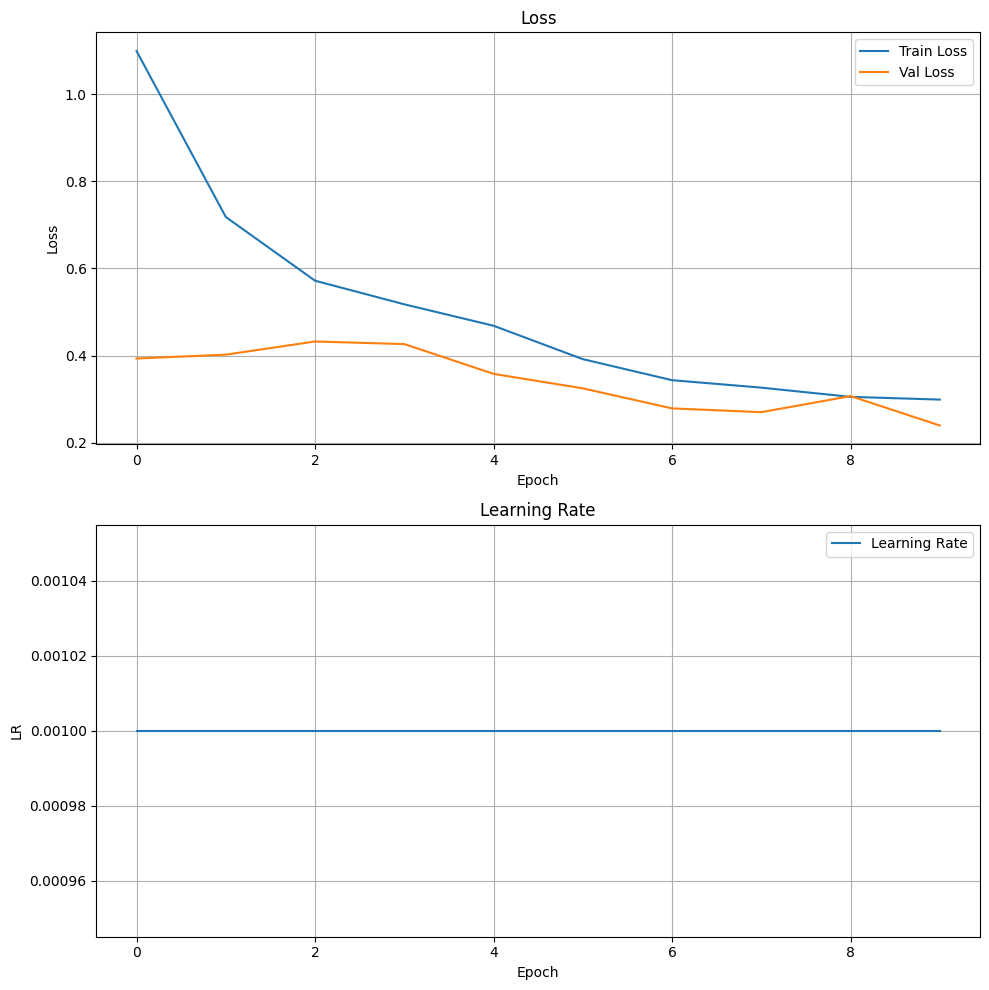

Current epoch: 10
Best loss: 0.2397
Current loss: 0.2992
Current learning rate: 0.001000
Best dice: 0.1218
Epoch 11/50: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]
Epoch 11, Train Loss: 0.2663, Val Loss: 0.1937, Mean Dice: 0.1088, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_011.pth
Best model saved.
Epoch 12/50: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]
Epoch 12, Train Loss: 0.2682, Val Loss: 0.2438, Mean Dice: 0.1204, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_012.pth
Epoch 13/50: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]
Epoch 13, Train Loss: 0.2397, Val Loss: 0.2659, Mean Dice: 0.1058, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_013.pth
Epoch 14/50: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]
Epoch 14, Train Loss: 0.2296, Val Loss: 0.258

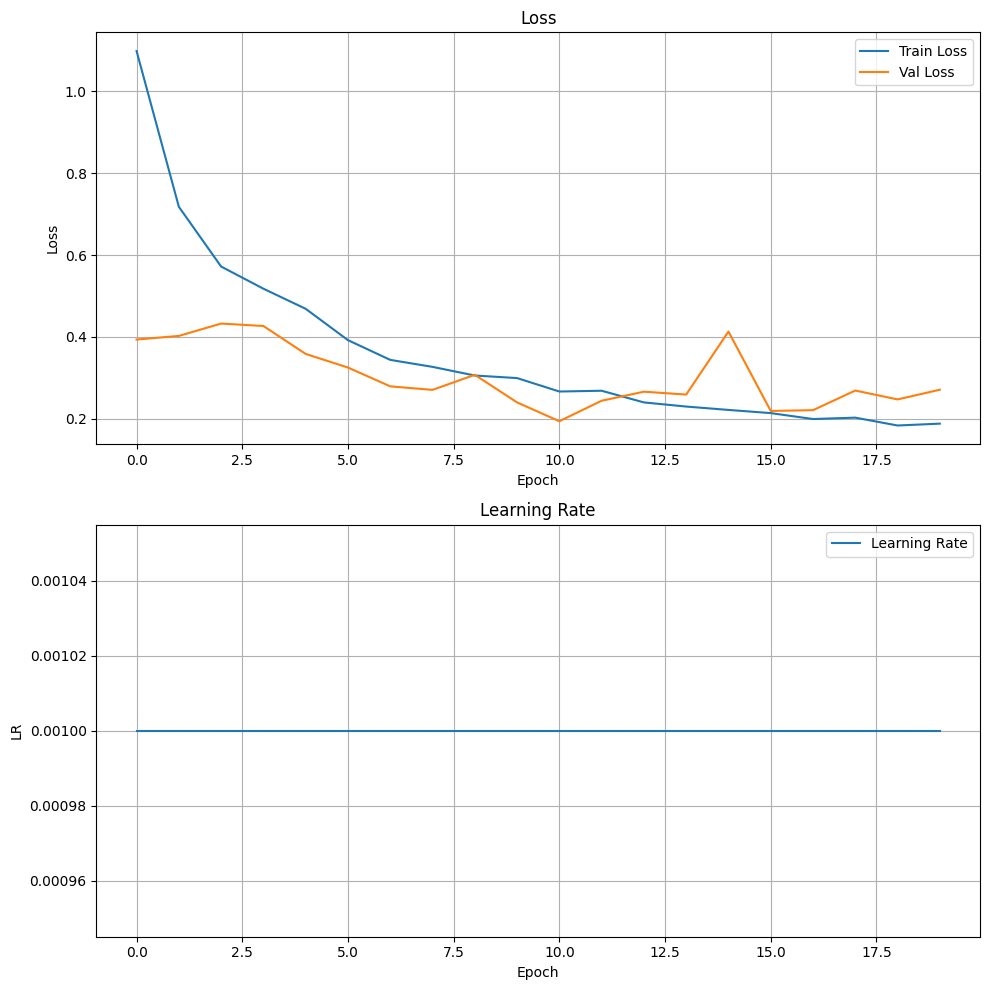

Current epoch: 20
Best loss: 0.1937
Current loss: 0.1878
Current learning rate: 0.001000
Best dice: 0.1222
Epoch 21/50: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]
Epoch 21, Train Loss: 0.1839, Val Loss: 0.3028, Mean Dice: 0.0858, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_021.pth
Epoch 22/50: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]
Epoch 22, Train Loss: 0.1754, Val Loss: 0.1803, Mean Dice: 0.1154, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_022.pth
Best model saved.
Epoch 23/50: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]
Epoch 23, Train Loss: 0.1633, Val Loss: 0.2762, Mean Dice: 0.0952, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_023.pth
Epoch 24/50: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]
Epoch 24, Train Loss: 0.1809, Val Loss: 0.311

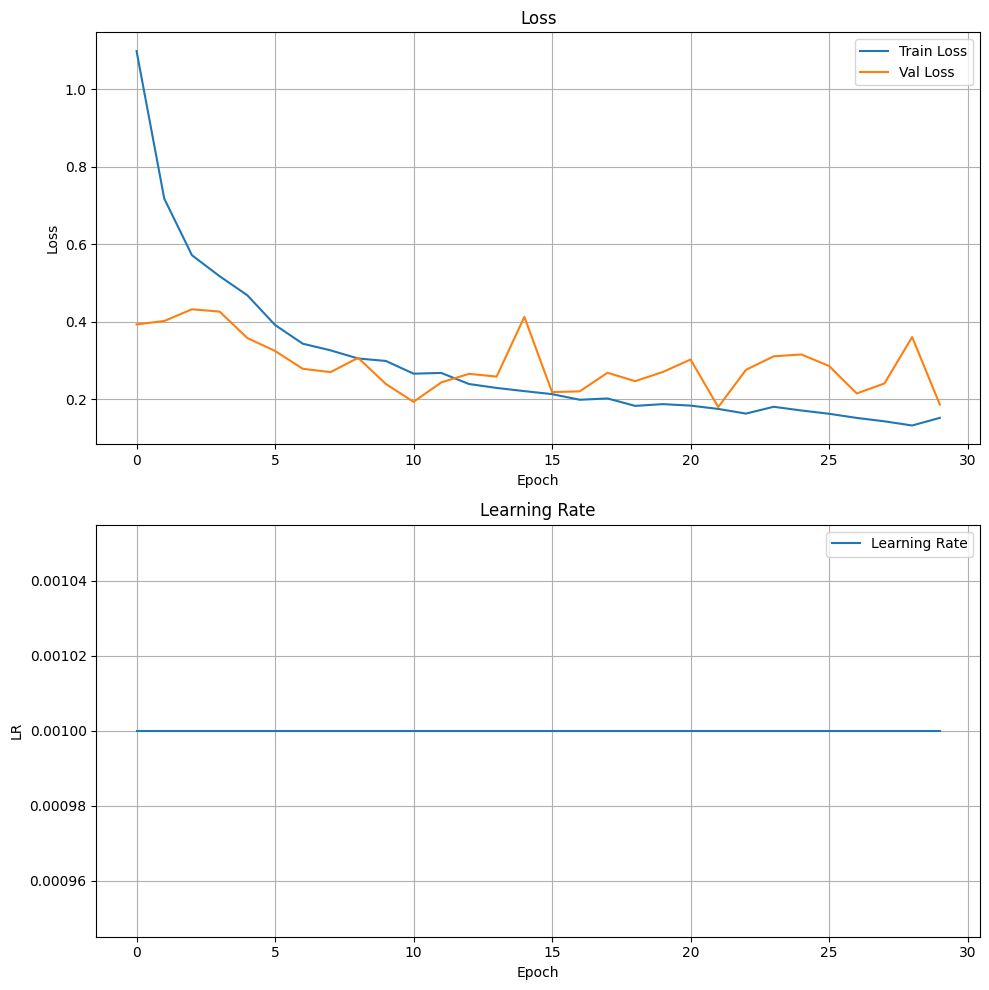

Current epoch: 30
Best loss: 0.1803
Current loss: 0.1524
Current learning rate: 0.001000
Best dice: 0.1222
Epoch 31/50: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]
Epoch 31, Train Loss: 0.1292, Val Loss: 0.2463, Mean Dice: 0.0833, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_031.pth
Epoch 32/50: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]
Epoch 32, Train Loss: 0.1264, Val Loss: 0.2861, Mean Dice: 0.0970, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_032.pth
Epoch 33/50: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]
Epoch 33, Train Loss: 0.1322, Val Loss: 0.2354, Mean Dice: 0.0854, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_033.pth
Epoch 34/50: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]
Epoch 34, Train Loss: 0.1341, Val Loss: 0.3191, Mean Dice: 0.09

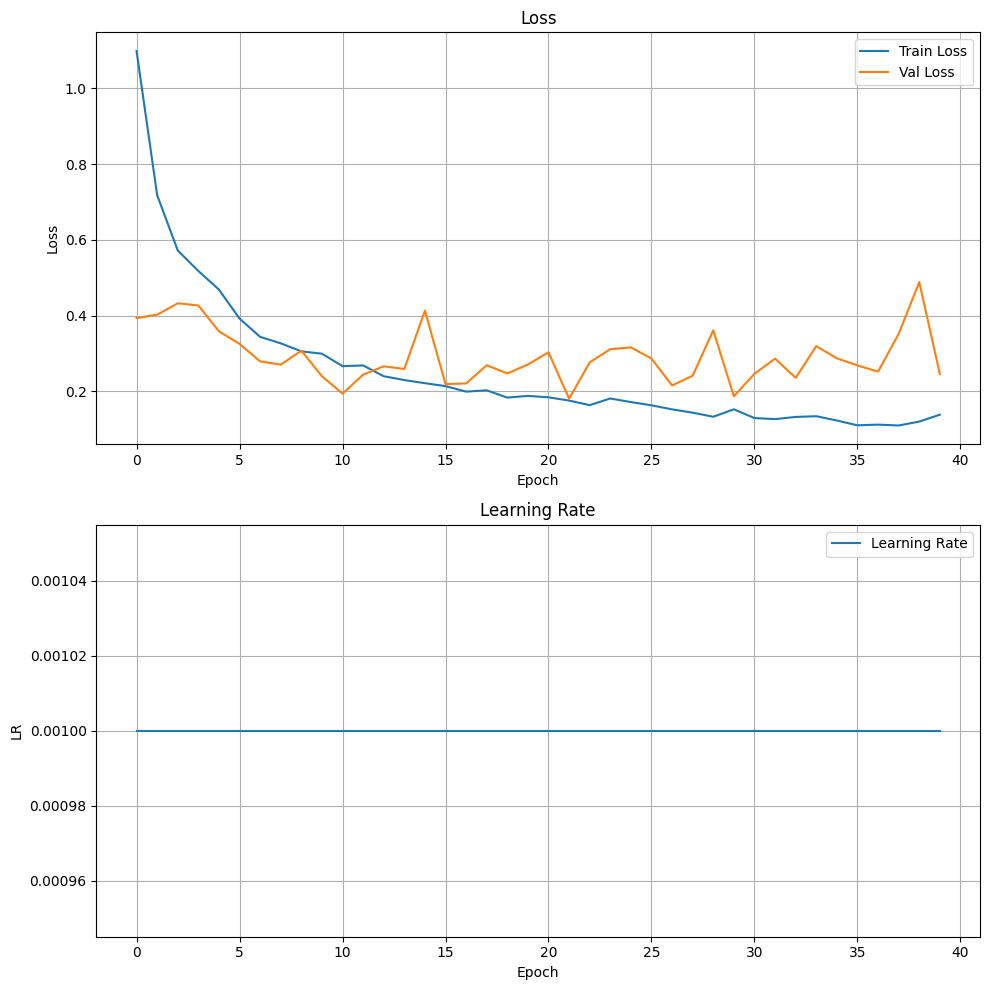

Current epoch: 40
Best loss: 0.1803
Current loss: 0.1381
Current learning rate: 0.001000
Best dice: 0.1303
Epoch 41/50: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]
Epoch 41, Train Loss: 0.1167, Val Loss: 0.2735, Mean Dice: 0.1064, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_041.pth
Epoch 42/50: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]
Epoch 42, Train Loss: 0.1165, Val Loss: 0.3357, Mean Dice: 0.1103, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_042.pth
Epoch 43/50: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]
Epoch 43, Train Loss: 0.1070, Val Loss: 0.3304, Mean Dice: 0.1039, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/sacrum/checkpoint_epoch_043.pth
Epoch 44/50: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]
Epoch 44, Train Loss: 0.1048, Val Loss: 0.2518, Mean Dice: 0.13

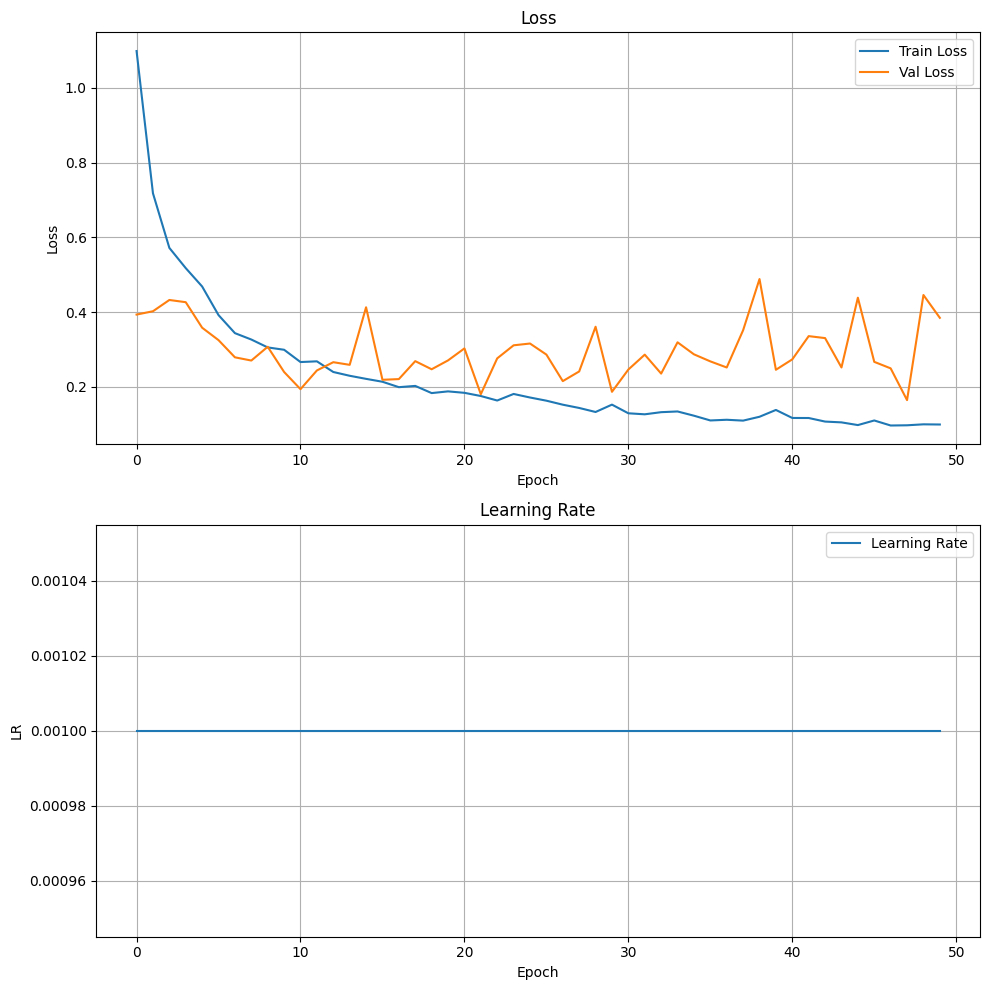

Current epoch: 50
Best loss: 0.1644
Current loss: 0.0991
Current learning rate: 0.001000
Best dice: 0.1731
sacrum骨折分割模型已保存！
加载 left_hip 的ROI数据...
成功加载 left_hip 数据: 100 个样本
Calculating class weights...
Epoch 1/50: 100%|██████████| 1000/1000 [09:42<00:00,  1.72it/s]
Epoch 1, Train Loss: 1.2993, Val Loss: 0.5389, Mean Dice: 0.0285, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/left_hip/checkpoint_epoch_001.pth
Best model saved.
Epoch 2/50: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]
Epoch 2, Train Loss: 0.9550, Val Loss: 0.3358, Mean Dice: 0.0311, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/left_hip/checkpoint_epoch_002.pth
Best model saved.
Epoch 3/50: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]
Epoch 3, Train Loss: 0.8037, Val Loss: 0.3464, Mean Dice: 0.0343, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/left_hip/checkpoint_epoch_003.pt

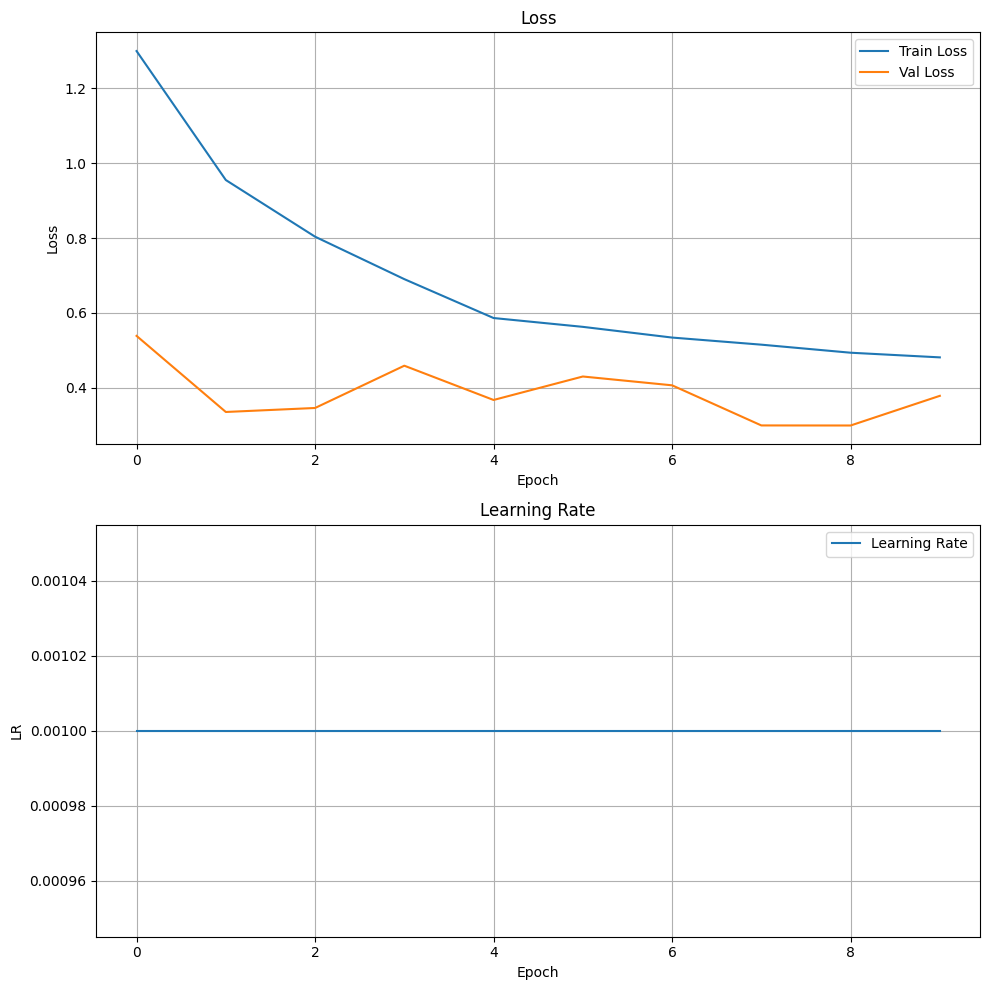

Current epoch: 10
Best loss: 0.2996
Current loss: 0.4815
Current learning rate: 0.001000
Best dice: 0.1046
Epoch 11/50: 100%|██████████| 1000/1000 [09:39<00:00,  1.72it/s]
Epoch 11, Train Loss: 0.4475, Val Loss: 0.2896, Mean Dice: 0.1000, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/left_hip/checkpoint_epoch_011.pth
Best model saved.
Epoch 12/50: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]
Epoch 12, Train Loss: 0.4759, Val Loss: 0.4179, Mean Dice: 0.0818, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/left_hip/checkpoint_epoch_012.pth
Epoch 13/50: 100%|██████████| 1000/1000 [09:39<00:00,  1.72it/s]
Epoch 13, Train Loss: 0.4339, Val Loss: 0.3370, Mean Dice: 0.0832, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/left_hip/checkpoint_epoch_013.pth
Epoch 14/50: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]
Epoch 14, Train Loss: 0.4435, Val Loss:

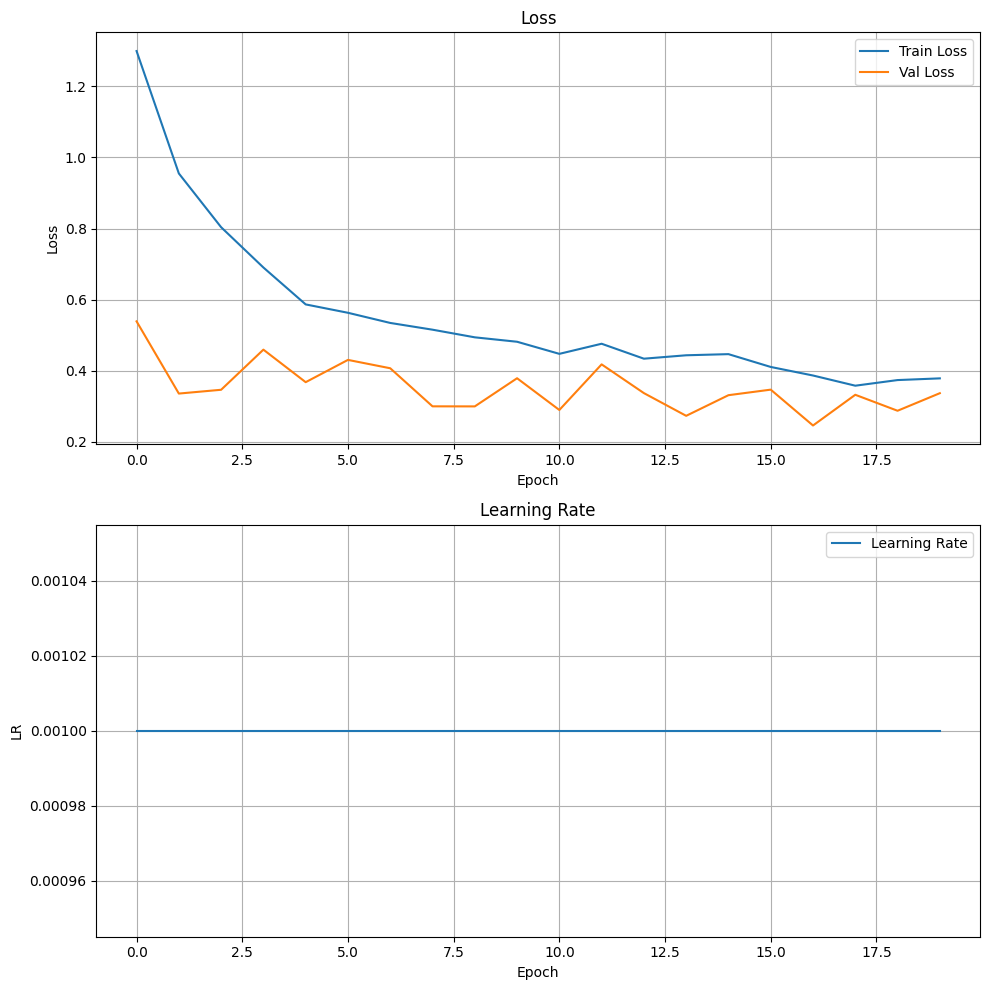

Current epoch: 20
Best loss: 0.2459
Current loss: 0.3785
Current learning rate: 0.001000
Best dice: 0.1046
Epoch 21/50: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]
Epoch 21, Train Loss: 0.3349, Val Loss: 0.2881, Mean Dice: 0.0677, LR: 0.001000
Checkpoint saved: /content/drive/MyDrive/ct_segmentation/3stage/models/stage3/left_hip/checkpoint_epoch_021.pth
Epoch 22/50:  85%|████████▍ | 848/1000 [08:11<01:27,  1.73it/s]

In [ ]:
# =========================================
# 第三段：骨折分割模型训练（阶段3）
# =========================================
# 只做骨折分割模型训练，依赖第二段npy，输出3个骨折模型pth
if __name__ == '__main__':
    import torch
    import numpy as np
    import os
    from sklearn.model_selection import train_test_split

    # 使用Colab路径
    BASE_DIR = '/content/drive/MyDrive/ct_segmentation'
    THREESTAGE_DIR = os.path.join(BASE_DIR, '3stage')
    PATHS = {
        'models': f'{THREESTAGE_DIR}/models',
        'roi_cache': f'{THREESTAGE_DIR}/roi_cache'
    }
    roi_cache_dir = PATHS['roi_cache']
    save_dir2 = os.path.join(THREESTAGE_DIR, 'models/stage3')
    os.makedirs(save_dir2, exist_ok=True)

    for bone_name in ['sacrum', 'left_hip', 'right_hip']:
        print(f"加载 {bone_name} 的ROI数据...")
        roi_path = os.path.join(roi_cache_dir, f'{bone_name}_roi_images.npy')
        label_path = os.path.join(roi_cache_dir, f'{bone_name}_roi_labels.npy')

        # 确认文件存在
        if not os.path.exists(roi_path) or not os.path.exists(label_path):
            print(f"错误: {bone_name} 的ROI文件不存在: {roi_path}")
            continue

        roi_images = np.load(roi_path, allow_pickle=True)
        roi_labels = np.load(label_path, allow_pickle=True)

        # 打印数据信息
        print(f"成功加载 {bone_name} 数据: {len(roi_images)} 个样本")

        bone_save_dir = os.path.join(save_dir2, bone_name)
        os.makedirs(bone_save_dir, exist_ok=True)
        train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(roi_images, roi_labels, test_size=0.1, random_state=42)
        train_dataset = FracturePatchDataset(train_imgs, train_lbls, patch_size=(128,128,128), num_patches=1000, augment=True)
        val_dataset = FracturePatchDataset(val_imgs, val_lbls, patch_size=(128,128,128), num_patches=100, augment=False)
        resume_ckpt = None  # 可选: os.path.join(bone_save_dir, f'checkpoint_epoch_008.pth')
        model = train_fracture_segmentation(
            train_dataset, val_dataset, bone_save_dir, num_classes=11, batch_size=2, num_epochs=50, accumulation_steps=4, resume_from=resume_ckpt
        )
        torch.save(model.state_dict(), os.path.join(bone_save_dir, f'best_fracture_model_{bone_name}.pth'))
        print(f'{bone_name}骨折分割模型已保存！')



# 第四段：级联推理与评估（阶段4）

 只做级联推理与评估，依赖所有pth和npy，输出推理结果和评估

In [ ]:
# =========================================
# 第四段：级联推理与评估（阶段4）
# =========================================
# 只做级联推理与评估，依赖所有pth和npy，输出推理结果和评估
if __name__ == '__main__':
    import torch
    import numpy as np
    import os
    import SimpleITK as sitk

    # 使用Colab路径
    BASE_DIR = '/content/drive/MyDrive/ct_segmentation'
    THREESTAGE_DIR = os.path.join(BASE_DIR, '3stage')
    PATHS = {
        'data': f'{BASE_DIR}/data',
        'models': f'{THREESTAGE_DIR}/models'
    }

    # 使用Colab路径
    save_dir1 = os.path.join(PATHS['models'], 'pelvis_stage1')
    save_dir2 = os.path.join(PATHS['models'], 'stage3')
    train_images = '/content/data/images/PENGWIN_CT_train_images'
    train_labels = '/content/data/labels/PENGWIN_CT_train_labels'
    results_dir = os.path.join(THREESTAGE_DIR, 'results')
    os.makedirs(results_dir, exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pelvis_model = UNet3D(in_channels=1, out_channels=4)

    # 检查模型文件存在性
    pelvis_model_path = os.path.join(save_dir1, 'best_pelvis_model.pth')
    if not os.path.exists(pelvis_model_path):
        print(f"错误: 骨盆模型文件不存在: {pelvis_model_path}")
    else:
        pelvis_model.load_state_dict(torch.load(pelvis_model_path, map_location=device))
        pelvis_model = pelvis_model.to(device)
        pelvis_model.eval()

        fracture_models = {}
        for bone_name in ['sacrum', 'left_hip', 'right_hip']:
            model = UNet3D(in_channels=1, out_channels=11)
            model_path = os.path.join(save_dir2, bone_name, f'best_fracture_model_{bone_name}.pth')
            if not os.path.exists(model_path):
                print(f"警告: {bone_name}骨折模型文件不存在: {model_path}")
                continue

            model.load_state_dict(torch.load(model_path, map_location=device))
            model = model.to(device)
            model.eval()
            fracture_models[bone_name] = model

        # 确保至少加载了一个骨折模型
        if len(fracture_models) == 0:
            print("错误: 没有找到任何可用的骨折模型!")
        else:
            print(f"成功加载 {len(fracture_models)} 个骨折模型")

            # 获取测试图像
            val_image_files = [f for f in sorted(os.listdir(train_images)) if f.endswith('.mha')][:1]
            val_label_files = [f for f in sorted(os.listdir(train_labels)) if f.endswith('.mha')][:1]
            val_image_list = [sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(train_images, f))).astype(np.float32) for f in val_image_files]
            val_label_list = [sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(train_labels, f))).astype(np.int64) for f in val_label_files]

            for idx, (img, lbl) in enumerate(zip(val_image_list, val_label_list)):
                print(f"处理测试样本 {idx+1}/{len(val_image_list)}...")
                result = cascaded_inference(pelvis_model, fracture_models, img, device)
                dices, mean_dice = dice_score(result, lbl, num_classes=31)
                ious, mean_iou = iou_score(result, lbl, num_classes=31)
                print(f'样本{idx} Dice: {dices}, Mean Dice: {mean_dice:.4f}, IoU: {ious}, Mean IoU: {mean_iou:.4f}')

                # 可视化结果
                plot_slice(img, lbl, result, num_classes=31)
                plot_three_views(img, lbl, result, num_classes=31)

                # 保存结果到Colab路径
                save_path = os.path.join(results_dir, f'result_case_{idx}.mha')
                save_segmentation_result(result, os.path.join(train_images, val_image_files[idx]), save_path)
                print(f'分割结果已保存到: {save_path}')

# 函数已在文件前部定义，此处为重复定义，已删除

# 在第二段主脚本中更新THREESTAGE_DIR路径下的visualization_dir
if __name__ == '__main__':
    # 路径设置
    BASE_DIR = '/content/drive/MyDrive/ct_segmentation'
    THREESTAGE_DIR = os.path.join(BASE_DIR, '3stage')
    visualization_dir = os.path.join(THREESTAGE_DIR, 'visualizations')
    os.makedirs(visualization_dir, exist_ok=True)


## 评估代码

Processing 001.mha ...


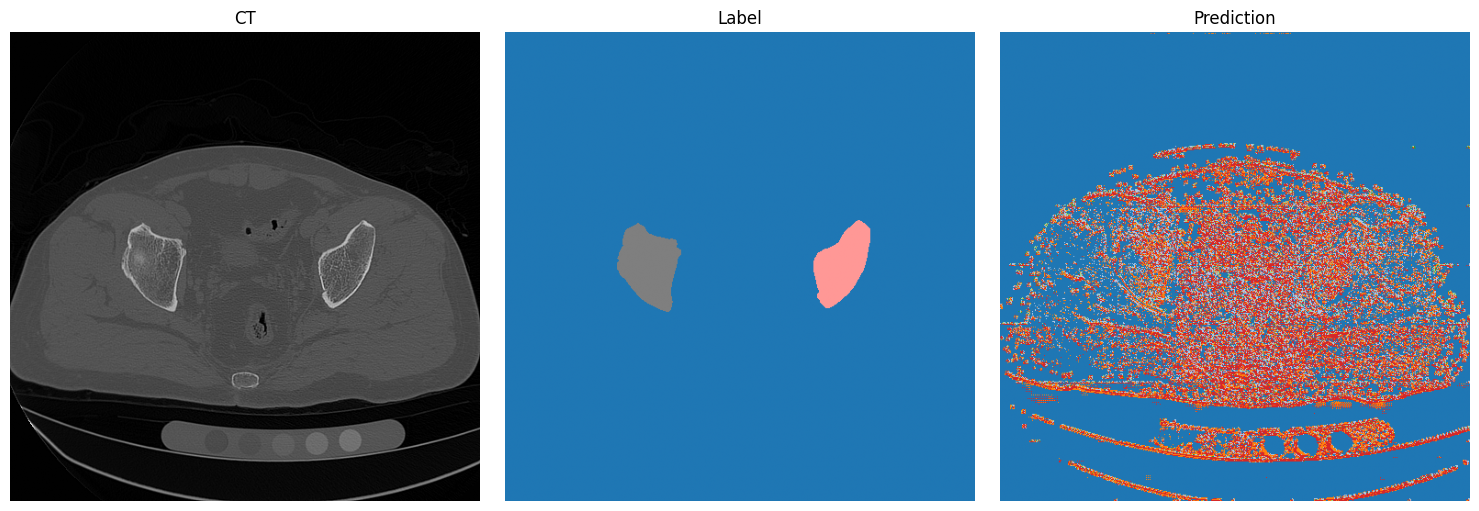

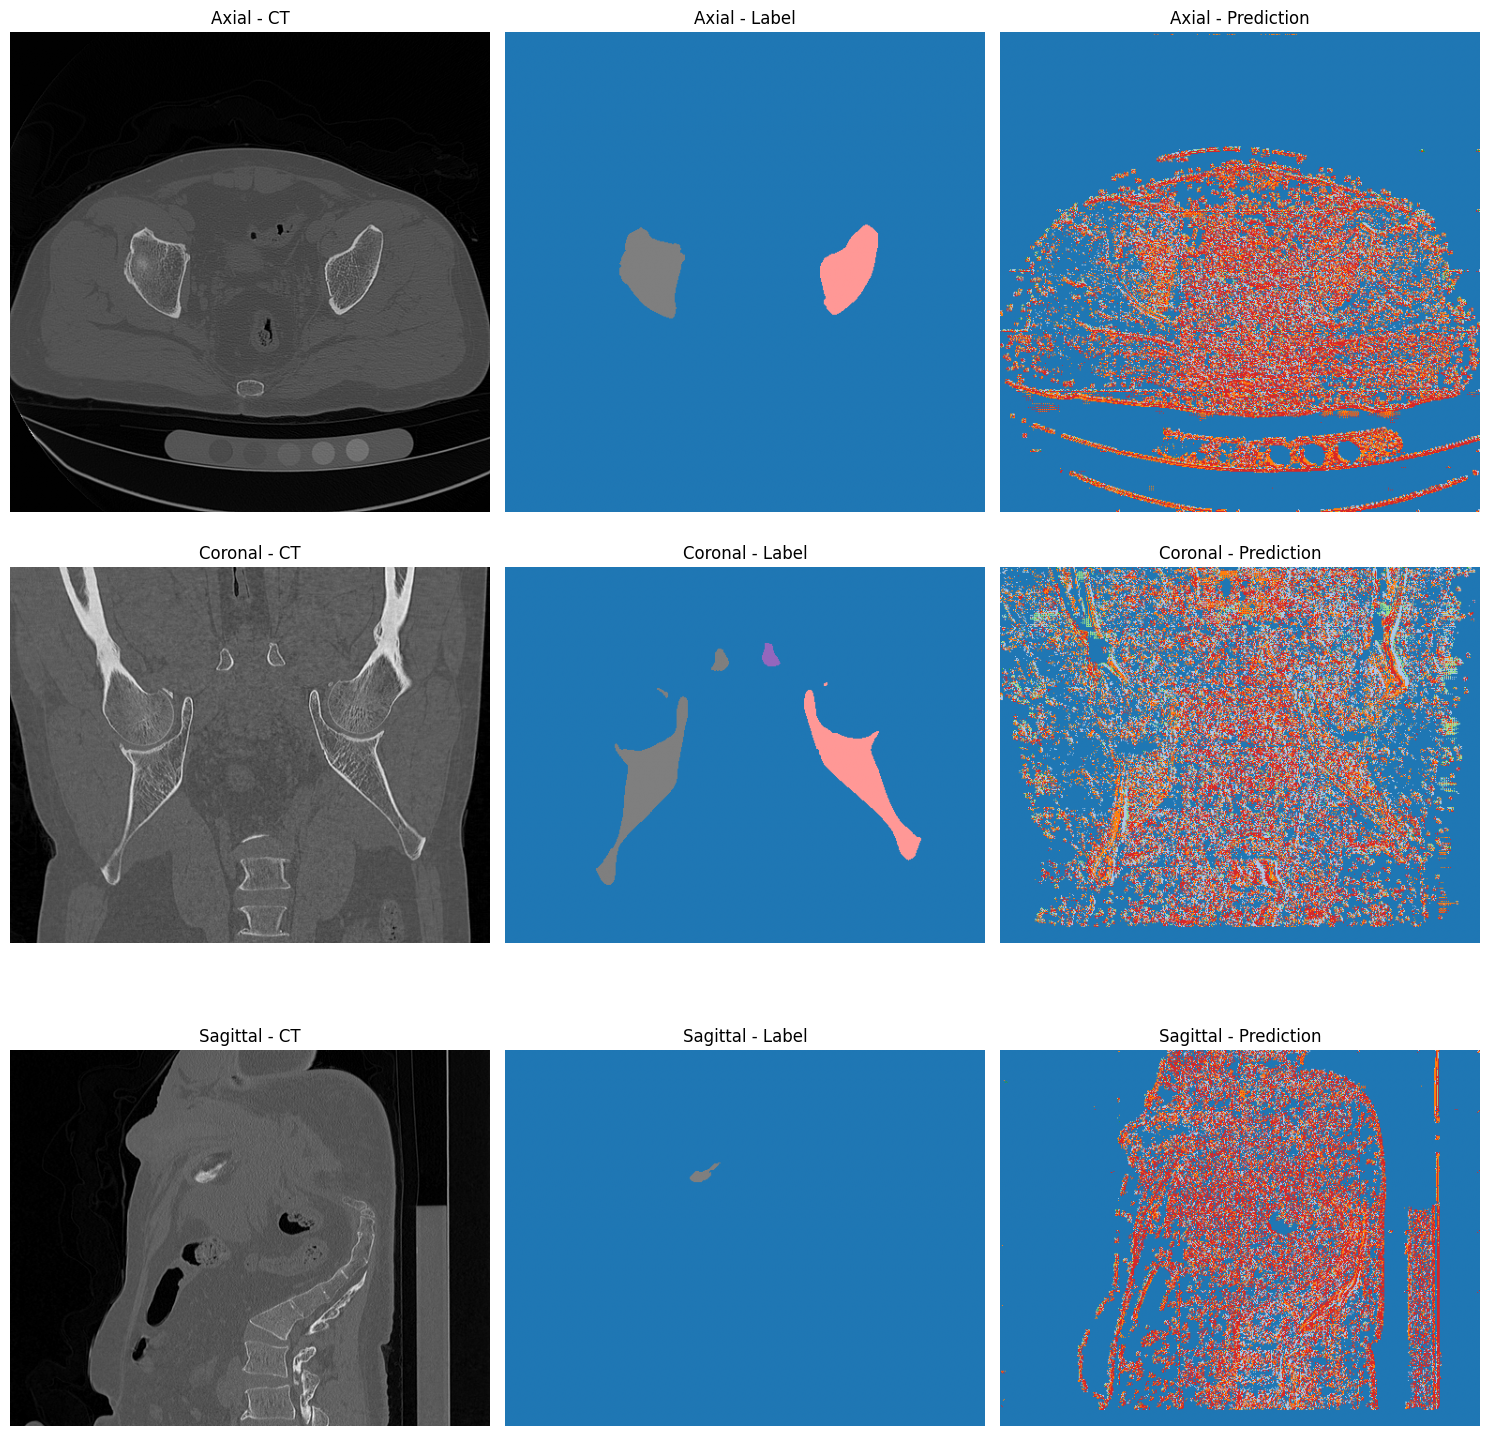

分割结果已保存到: ./eval_results/result_case_0.mha
Processing 002.mha ...


KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import torch
import SimpleITK as sitk

# 路径配置
pelvis_model_path = '/content/drive/MyDrive/ct_segmentation/3stage/models/pelvis_stage1/best_pelvis_model.pth'
fracture_model_path = '/content/drive/MyDrive/ct_segmentation/3stage/models/fracture_stage2/best_fracture_model.pth'
test_images_dir = '/content/data/images/PENGWIN_CT_train_images'
test_labels_dir = '/content/data/labels/PENGWIN_CT_train_labels'
save_result_dir = './eval_results'
os.makedirs(save_result_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pelvis_model = UNet3D(in_channels=1, out_channels=4)
pelvis_model.load_state_dict(torch.load(pelvis_model_path, map_location=device))
pelvis_model = pelvis_model.to(device)
pelvis_model.eval()

fracture_model = UNet3D(in_channels=1, out_channels=11)
fracture_model.load_state_dict(torch.load(fracture_model_path, map_location=device))
fracture_model = fracture_model.to(device)
fracture_model.eval()

image_files = sorted([f for f in os.listdir(test_images_dir) if f.endswith('.mha')])
label_files = sorted([f for f in os.listdir(test_labels_dir) if f.endswith('.mha')])
N = 5
image_files = image_files[:N]
label_files = label_files[:N]

fracture_ious, fracture_assds, fracture_hd95s = [], [], []
anatomical_ious, anatomical_assds, anatomical_hd95s = [], [], []

for idx, (img_name, lbl_name) in enumerate(zip(image_files, label_files)):
    print(f'Processing {img_name} ...')
    img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(test_images_dir, img_name))).astype(np.float32)
    lbl = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(test_labels_dir, lbl_name))).astype(np.int64)
    result = cascaded_inference(pelvis_model, fracture_model, img, device)
    if result is None:
        print(f'样本{idx}未检测到目标骨结构，跳过')
        continue

    # fracture: 只统计1-10号标签
    f_iou, f_iou_mean = iou_score(result, lbl, num_classes=11)
    f_assd, f_assd_mean = assd(result, lbl, num_classes=11)
    f_hd95, f_hd95_mean = hd95(result, lbl, num_classes=11)
    fracture_ious.append(f_iou_mean)
    fracture_assds.append(f_assd_mean)
    fracture_hd95s.append(f_hd95_mean)

    # anatomical: 只统计1/2/3号标签
    a_iou, a_iou_mean = iou_score(result, lbl, num_classes=4)
    a_assd, a_assd_mean = assd(result, lbl, num_classes=4)
    a_hd95, a_hd95_mean = hd95(result, lbl, num_classes=4)
    anatomical_ious.append(a_iou_mean)
    anatomical_assds.append(a_assd_mean)
    anatomical_hd95s.append(a_hd95_mean)

    # 可视化
    plot_slice(img, lbl, result, num_classes=31, save_path=os.path.join(save_result_dir, f'slice_{idx}.png'))
    plot_three_views(img, lbl, result, num_classes=31, save_path=os.path.join(save_result_dir, f'three_views_{idx}.png'))
    save_path = os.path.join(save_result_dir, f'result_case_{idx}.mha')
    save_segmentation_result(result, os.path.join(test_images_dir, img_name), save_path)
    print(f'分割结果已保存到: {save_path}')

# 汇总
print('\nAggregates:')
print(f'"fracture_iou": {np.nanmean(fracture_ious):.6f},')
print(f'"fracture_assd": {np.nanmean(fracture_assds):.6f},')
print(f'"fracture_hd95": {np.nanmean(fracture_hd95s):.6f},')
print(f'"anatomical_iou": {np.nanmean(anatomical_ious):.6f},')
print(f'"anatomical_assd": {np.nanmean(anatomical_assds):.6f},')
print(f'"anatomical_hd95": {np.nanmean(anatomical_hd95s):.6f}')

# 代码排查问题
##1.第一阶段ROI可视化


=== sacrum ROI标签类别分布统计 ===
sacrum ROI 0 标签分布: {np.int32(0): np.int64(3825101), np.int32(1): np.int64(458539)}
sacrum ROI 1 标签分布: {np.int32(0): np.int64(2768616), np.int32(1): np.int64(323928)}
sacrum ROI 2 标签分布: {np.int32(0): np.int64(3366386), np.int32(1): np.int64(314254)}
sacrum ROI 3 标签分布: {np.int32(0): np.int64(1661626), np.int32(1): np.int64(167936)}
sacrum ROI 4 标签分布: {np.int32(0): np.int64(1709686), np.int32(1): np.int64(194475)}
sacrum ROI 5 标签分布: {np.int32(0): np.int64(748733), np.int32(1): np.int64(76023)}
sacrum ROI 6 标签分布: {np.int32(0): np.int64(1972202), np.int32(1): np.int64(245006)}
sacrum ROI 7 标签分布: {np.int32(0): np.int64(3251866), np.int32(1): np.int64(346694)}
sacrum ROI 8 标签分布: {np.int32(0): np.int64(3165176), np.int32(1): np.int64(429559)}
sacrum ROI 9 标签分布: {np.int32(0): np.int64(2990815), np.int32(1): np.int64(273185)}
=== 可视化前3个sacrum ROI ===


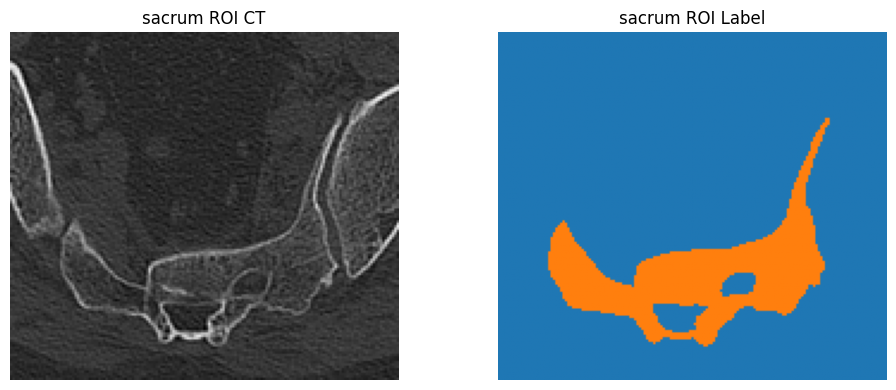

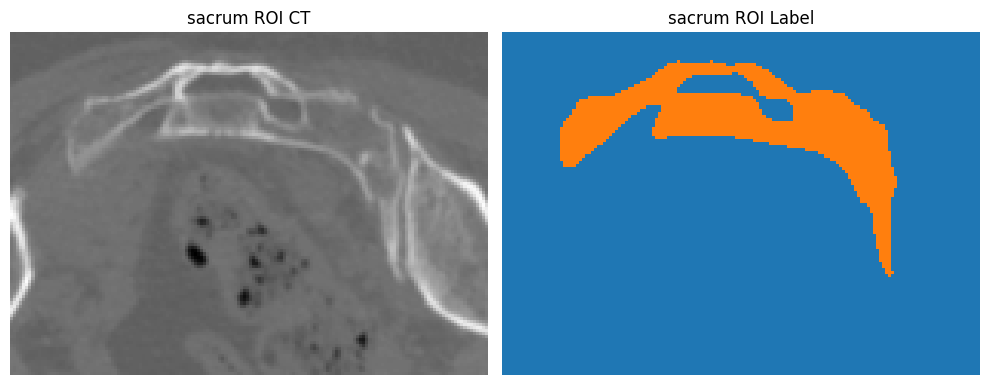

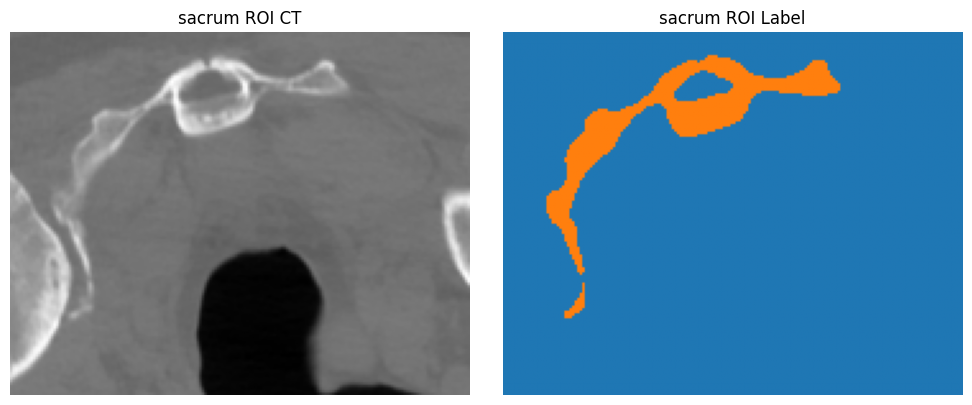

=== left_hip ROI标签类别分布统计 ===
left_hip ROI 0 标签分布: {np.int32(0): np.int64(246738)}
left_hip ROI 1 标签分布: {np.int32(0): np.int64(337014)}
left_hip ROI 2 标签分布: {np.int32(0): np.int64(676575)}
left_hip ROI 3 标签分布: {np.int32(0): np.int64(591192)}
left_hip ROI 4 标签分布: {np.int32(0): np.int64(819000)}
left_hip ROI 5 标签分布: {np.int32(0): np.int64(920550)}
left_hip ROI 6 标签分布: {np.int32(0): np.int64(337330)}
left_hip ROI 7 标签分布: {np.int32(0): np.int64(1429560)}
left_hip ROI 8 标签分布: {np.int32(0): np.int64(355180)}
left_hip ROI 9 标签分布: {np.int32(0): np.int64(393120)}
=== 可视化前3个left_hip ROI ===


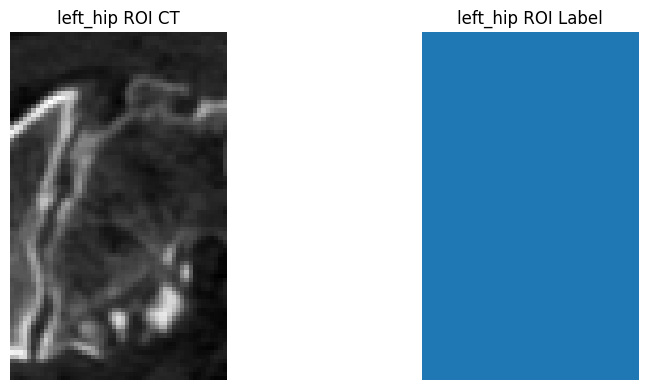

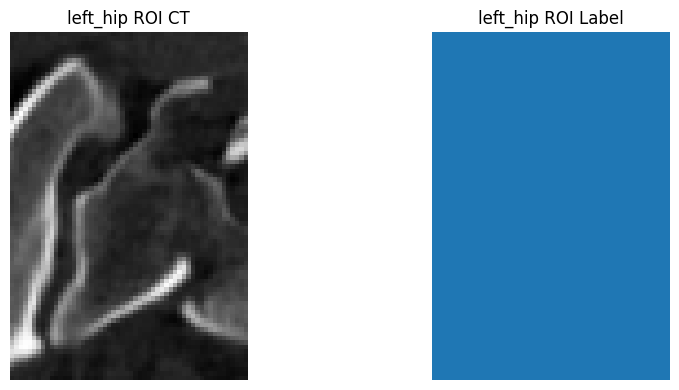

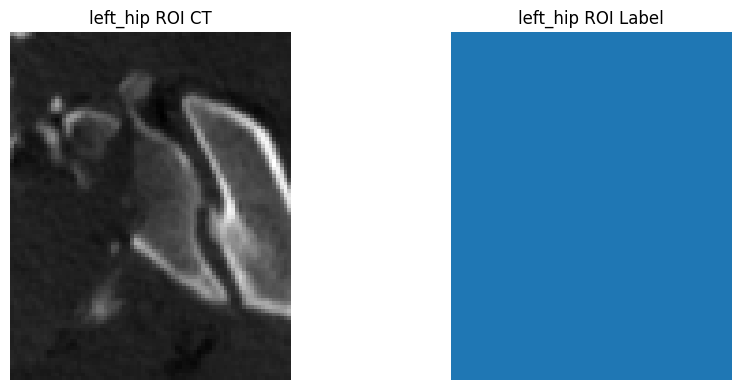

=== right_hip ROI标签类别分布统计 ===
right_hip ROI 0 标签分布: {0: np.int64(534600)}
right_hip ROI 1 标签分布: {0: np.int64(275176)}
right_hip ROI 2 标签分布: {np.int32(0): np.int64(125736)}
right_hip ROI 3 标签分布: {np.int32(0): np.int64(1403600)}
right_hip ROI 4 标签分布: {np.int32(0): np.int64(790468)}
right_hip ROI 5 标签分布: {0: np.int64(67240)}
right_hip ROI 6 标签分布: {0: np.int64(1779624)}
=== 可视化前3个right_hip ROI ===


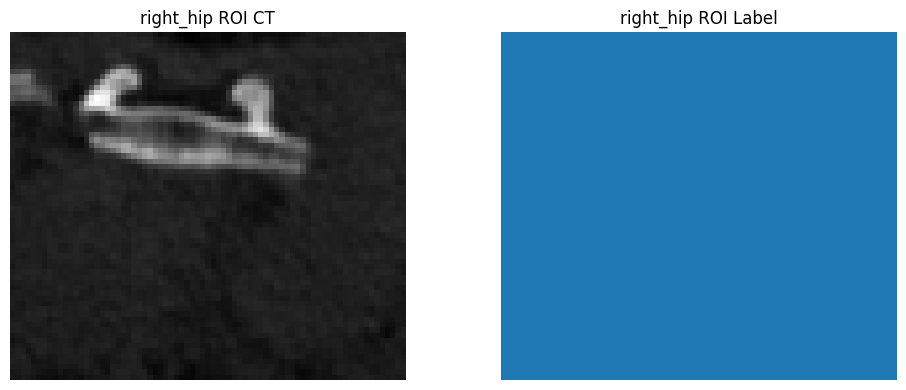

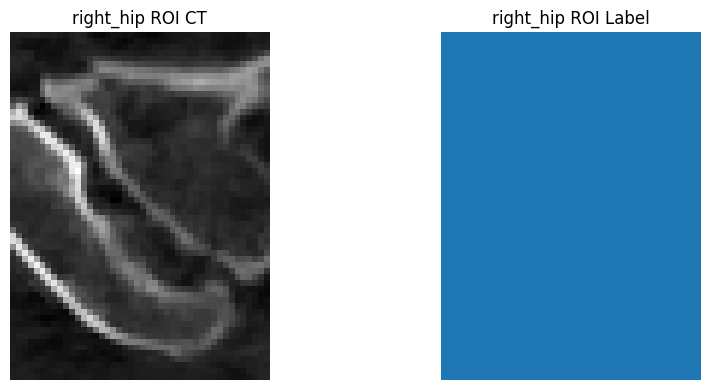

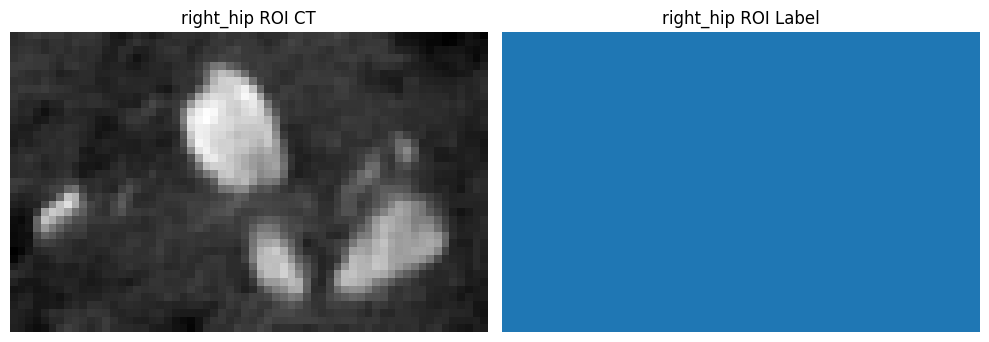

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ROI缓存路径
roi_cache_dir = '/content/drive/MyDrive/ct_segmentation/3stage/roi_cache'

roi_files = [
    ('sacrum', 'sacrum_roi_images.npy', 'sacrum_roi_labels.npy'),
    ('left_hip', 'left_hip_roi_images.npy', 'left_hip_roi_labels.npy'),
    ('right_hip', 'right_hip_roi_images.npy', 'right_hip_roi_labels.npy'),
]

def plot_slice(image, label, slice_idx=None, num_classes=11, title_prefix=''):
    # 转为标准ndarray和合适类型
    image = np.asarray(image)
    label = np.asarray(label)
    if image.dtype == object and image.shape[0] == 1:
        image = image[0]
    if label.dtype == object and label.shape[0] == 1:
        label = label[0]
    image = image.astype(np.float32)
    label = label.astype(np.int32)
    if slice_idx is None:
        slice_idx = image.shape[0] // 2
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(image[slice_idx], cmap='gray')
    plt.title(f'{title_prefix} ROI CT')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(label[slice_idx], cmap='tab20', vmin=0, vmax=num_classes-1)
    plt.title(f'{title_prefix} ROI Label')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

for bone_name, img_file, lbl_file in roi_files:
    print(f'=== {bone_name} ROI标签类别分布统计 ===')
    roi_images = np.load(os.path.join(roi_cache_dir, img_file), allow_pickle=True)
    roi_labels = np.load(os.path.join(roi_cache_dir, lbl_file), allow_pickle=True)
    for idx, roi_lbl in enumerate(roi_labels):
        unique, counts = np.unique(roi_lbl, return_counts=True)
        print(f"{bone_name} ROI {idx} 标签分布: {dict(zip(unique, counts))}")
        if idx >= 9:
            break
    print(f'=== 可视化前3个{bone_name} ROI ===')
    for i in range(min(3, len(roi_images))):
        roi_img = roi_images[i]
        roi_lbl = roi_labels[i]
        plot_slice(roi_img, roi_lbl, num_classes=11, title_prefix=bone_name)

=== 随机采样patch标签类别分布 ===
Patch 0 标签分布: {np.int64(0): np.int64(1804232), np.int64(1): np.int64(292920)}


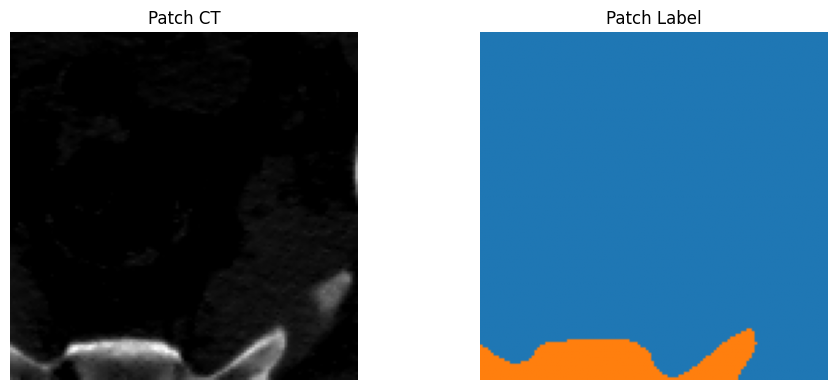

Patch 1 标签分布: {np.int64(0): np.int64(1732621), np.int64(1): np.int64(364531)}


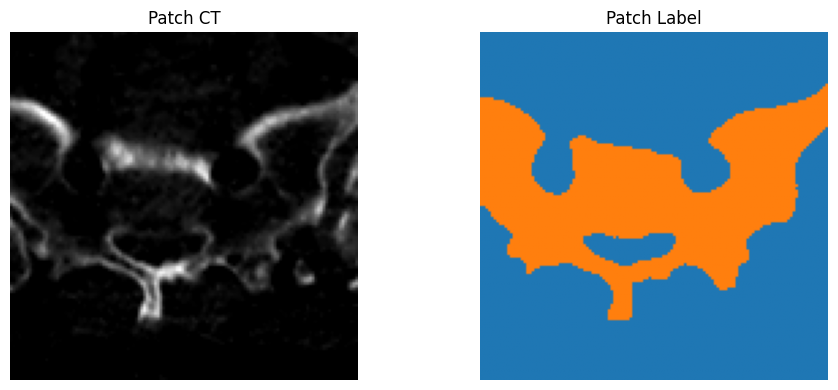

Patch 2 标签分布: {np.int64(0): np.int64(1910422), np.int64(1): np.int64(186730)}


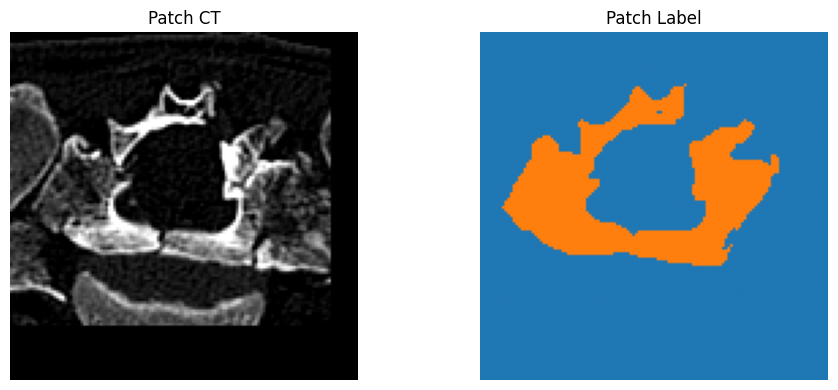

Patch 3 标签分布: {np.int64(0): np.int64(1773749), np.int64(1): np.int64(323403)}


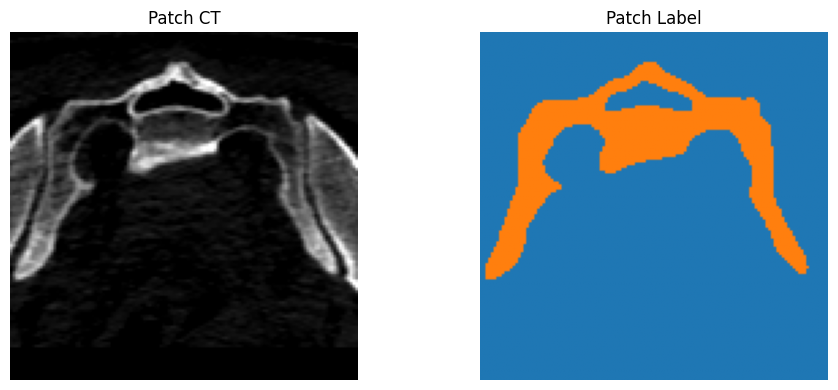

Patch 4 标签分布: {np.int64(0): np.int64(1830386), np.int64(1): np.int64(266766)}


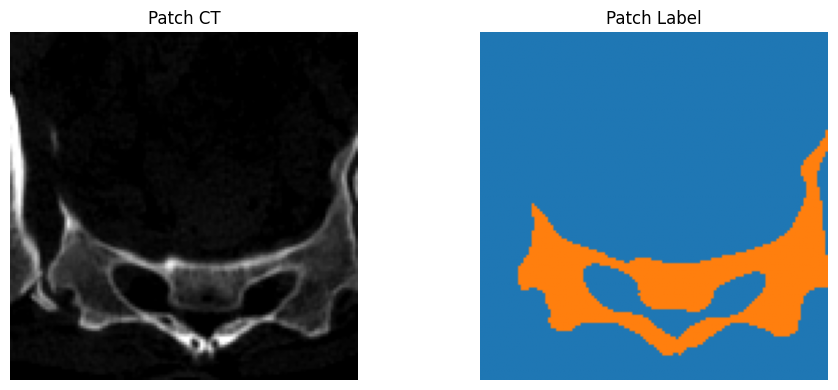

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ROI缓存路径
local_cache_dir = '/content/roi_cache'
roi_local_path = os.path.join(local_cache_dir, 'roi_images.npy')
lbl_local_path = os.path.join(local_cache_dir, 'roi_labels.npy')

# 加载ROI数据
roi_images = np.load(roi_local_path, allow_pickle=True)
roi_labels = np.load(lbl_local_path, allow_pickle=True)

# 初始化FracturePatchDataset
patch_size = (128, 128, 128)
dataset = FracturePatchDataset(roi_images, roi_labels, patch_size=patch_size, num_patches=100, augment=False)

print('=== 随机采样patch标签类别分布 ===')
for i in range(5):
    img, lbl = dataset[np.random.randint(0, len(dataset))]
    lbl_np = lbl.numpy()
    unique, counts = np.unique(lbl_np, return_counts=True)
    print(f"Patch {i} 标签分布: {dict(zip(unique, counts))}")
    # 可视化patch中间切片
    slice_idx = lbl_np.shape[0] // 2
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img.numpy()[0, slice_idx], cmap='gray')
    plt.title('Patch CT')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(lbl_np[slice_idx], cmap='tab20', vmin=0, vmax=10)
    plt.title('Patch Label')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

clean cuda memory

In [ ]:
import torch
import gc

def cleanup_cuda():
    # Clear GPU cache
    torch.cuda.empty_cache()

    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats()

    # Get current device
    device = torch.cuda.current_device()

    # Print memory stats before cleanup
    print("Memory stats before cleanup:")
    print(f"Allocated: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
    print(f"Cached: {torch.cuda.memory_reserved(device) / 1024**2:.2f} MB")

    # Clear all PyTorch tensors
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                del obj
            elif hasattr(obj, 'data') and torch.is_tensor(obj.data):
                del obj.data
        except:
            pass

    # Run garbage collector
    gc.collect()
vvvvvvvvvvvvvvvvvv
    # Empty cache again
    torch.cuda.empty_cache()

    # Print memory stats after cleanup
    print("\nMemory stats after cleanup:")
    print(f"Allocated: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
    print(f"Cached: {torch.cuda.memory_reserved(device) / 1024**2:.2f} MB")
    print("\nCUDA memory cleaned!")

# Run the cleanup
cleanup_cuda()

Memory stats before cleanup:
Allocated: 96.68 MB
Cached: 158.00 MB


<ipython-input-16-9b6695d1e615>:24: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  elif hasattr(obj, 'data') and torch.is_tensor(obj.data):



Memory stats after cleanup:
Allocated: 96.68 MB
Cached: 158.00 MB

CUDA memory cleaned!
